## Airbnb Price Predictions: Accommodations in London


    1. Introduction

    2. Data Loading and Preprocessing
        2.1 Data Overview
        2.2 Data Type Conversion
        2.3 Missing Values 
        2.4 Text Cleaning

    3. Exploratory Data Analysis (EDA)
        3.1 Target Distribution (Price)
        3.2 Feature Distribution and Correlation Analysis

    4. Feature Engineering 
        4.1 Feature Transformation
        4.2 Feature Extraction

    5. Model Selection and Training
        5.1 Textual Features 
                - Disclaimer 
                - Lasso/Ridge Regression 
                - XGB 
        5.2 Numerical Features 
        5.1 Traditional Models 
                - Linear Regression
                - Random Forest
                - XGB
        5.2 Neural Network Architecture
                - Vanilla Neural Network 
                - Deep Neural Network
                - Wide and Deep Neural Network
                - Optimization and Hyperparameter-Tuning 
        5.3 Final Model Choice and Fine-Tuning¶

    6. Application to Test Set
        6.1 Preprocessing Test Data
        6.2 Price Estimation on Test Data 

    7. Conclusion

## 1. Introduction 

AirBnB, once founded by three roommates offering travelers an air-mattress in their San Francisco living room, has revolutionized the accomodations industry and is a global leader in unique travelling experiences with a yearly revenue in the billions. Airbnb has over 55.000 property listings in London alone, each with its unique attributes such as location, number of rooms, and property type. In addition to these tabular data, each listing is accompanied by textual descriptions and reviews that provide potential renters with a more qualitative understanding of the property.

In this assignment, our goal is to predict the rental price of these properties based on both their tabular attributes, textual descriptions and reviews. 

Please note that while weve aimed for reproducible randomness where feasible, complete model reproducibility cant be guaranteed.

In [245]:
# Load necessary packages
import math
import re
import nltk
import numpy as np
import pandas as pd
import scipy.sparse as sp
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
from help_functions import preprocess_test
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input, Dropout, concatenate
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from math import sqrt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## 2. Data Loading and Preprocessing

Please note that the steps in the chapters 2. and 3. are closely related. So, it can be hard to keep them completely separate. For example, some feature changes might be better done after changing data types, or more exploratory data analysis might be needed before deciding how to deal with missing values. Even though we tried to keep these sections separate, some mixing was bound to happen.

### 2.1 Data Overview
As always, we familirazie ourselves with the data first.

In [246]:
train = pd.read_csv("csv_files/train.csv", sep=",",index_col=False, encoding="utf-8")

In [247]:
pd.set_option('display.max_columns', 50)
print('Count of duplicated values:')
print(train.duplicated().sum())
print(' \nShape and overview: \n')
train.info()

Count of duplicated values:
0
 
Shape and overview: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55284 entries, 0 to 55283
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name                         55270 non-null  object 
 1   summary                      52330 non-null  object 
 2   space                        38403 non-null  object 
 3   description                  53558 non-null  object 
 4   experiences_offered          55284 non-null  object 
 5   neighborhood_overview        35778 non-null  object 
 6   transit                      35477 non-null  object 
 7   house_rules                  31905 non-null  object 
 8   picture_url                  55284 non-null  object 
 9   host_id                      55284 non-null  int64  
 10  host_since                   55173 non-null  object 
 11  host_response_time           37482 non-null  object 
 12  host_response_rate  

In [248]:
train['experiences_offered'].unique()

array(['business', 'none', 'romantic', 'family', 'social'], dtype=object)

In [249]:
print('Head of data: \n')
train.head(10)

Head of data: 



,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,listing_id
0,Attic Room in historic Greenwich,"The room does not have a door but its own discreet staircase. It is light, airy and open plan. The leaning ceiling provides a snug hideaway feel and benefits from a fine panoramic view of London.","Double room available in historic royal Greenwich; a UNESCO designated World Heritage Site for its significant contribution to the cultural and natural heritage of the world. The house is in a peaceful residential street that has panoramic views across London. Please Note that clean bedding and towels are provided and whilst I do not prepare breakfast you are welcome to make use of kitchen facilities, and sundries like cereal, fruit, milk, tea, coffee I may have in, for breakfast and light refreshments. The walk to the house is up hill. The attic room is on the second storey it has privacy but no door. The stairs have a tight turn at the top which makes trunks and very large suitcases difficult to maneuver - ask if assistance is required. A key for access to the house is available on request.","The room does not have a door but its own discreet staircase. It is light, airy and open plan. The leaning ceiling provides a snug hideaway feel and benefits from a fine panoramic view of London. Double room available in historic royal Greenwich; a UNESCO designated World Heritage Site for its significant contribution to the cultural and natural heritage of the world. The house is in a peaceful residential street that has panoramic views across London. Please Note that clean bedding and towels are provided and whilst I do not prepare breakfast you are welcome to make use of kitchen facilities, and sundries like cereal, fruit, milk, tea, coffee I may have in, for breakfast and light refreshments. The walk to the house is up hill. The attic room is on the second storey it has privacy but no door. The stairs have a tight turn at the top which makes trunks and very large suitcases difficult to maneuver - ask if assistance is required. A key for access to the house is available on reque",business,NaN,Parking is restricted in London. Visitors parking permits for my area are available for £5 per day. The house is a 10-12 miute walk from Greenwich rail station.,no shoes on carpets no food in attic room no other guests to be invited back to house,https://a0.muscache.com/im/pictures/20045164/7a62eb0c_original.jpg?aki_policy=large,2167992,2012-04-18,within an hour,100%,t,1.0,t,f,Greenwich,Greenwich,SE10 8SX,51.47457,-0.01062,Townhouse,Private room,2,1.0,1.0,1.0,Pull-out Sofa,"{Wifi,""Paid parking off premises"",Heating,Washer,""Smoke detector"",""Carbon monoxide detector"",""First aid kit"",Essentials,Shampoo,Hangers,""Hair dryer"",Iron,""Laptop friendly workspace"",""translation missing: en.hosting_amenity_49"",""translation missing: en.hosting_amenity_50"",""Hot water"",""Bed linens"",""Extra pillows and blankets"",""Dishes and silverware"",""Luggage dropoff allowed"",""Host greets you"",""Handheld shower head""}",35.0,1,95.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.37,9Q1RD6H7IO
1,Lovely Garden Studio Private Access,"Garden studio with private entrance, 5 minutes from Crouch End & its many shops & restaurants. All modern amenities - free high speed wifi, FreeviewTV, High pressure shower, comfy King bed, toaster/kettle/fridge. Lots of room and very quiet!","Beautiful studio with a

In [250]:
print('Descriptive statistics of numerical columns:')
train.describe(include=np.number)

Descriptive statistics of numerical columns:


,host_id,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,5.528400e+04,55173.000000,55284.000000,55284.000000,55284.000000,55214.000000,55222.000000,55022.000000,55284.000000,55284.000000,41869.000000,41836.000000,41842.000000,41801.000000,41838.000000,41804.000000,41804.000000,42904.000000
mean,8.817998e+07,20.704475,51.509971,-0.126962,3.131756,1.283850,1.373873,1.710661,104.308751,1.574832,92.533044,9.502868,9.261484,9.622043,9.652851,9.541623,9.262846,1.164464
std,9.013224e+07,117.029690,0.046741,0.093517,1.930209,0.566556,0.859448,1.224301,83.740407,1.263427,10.030620,0.982464,1.138548,0.894931,0.873805,0.810408,1.033351,1.353820
min,2.697000e+03,0.000000,51.294790,-0.496680,1.000000,0.000000,0.000000,0.000000,10.000000,1.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.010000
25%,1.526397e+07,1.000000,51.485300,-0.187632,2.000000,1.000000,1.000000,1.000000,45.000000,1.000000,90.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.240000
50%,4.816502e+07,2.000000,51.514330,-0.124510,2.000000,1.000000,1.000000,1.000000,80.000000,1.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,0.730000
75%,1.449050e+08,5.000000,51.537960,-0.068820,4.000000,1.500000,2.000000,2.000000,130.000000,2.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.570000
max,3.256719e+08,1321.000000,51.681690,0.285390,16.000000,11.000000,19.000000,21.000000,500.000000,46.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,22.040000


In [251]:
print('Descriptive statistics of categorical columns:')
train.describe(include=['object', 'category'])

Descriptive statistics of categorical columns:


,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_since,host_response_time,host_response_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,zipcode,property_type,room_type,bed_type,amenities,cancellation_policy,listing_id
count,55270,52330,38403,53558,55284,35778,35477,31905,55284,55173,37482,37482,55173,55173,55173,55137,55284,54012,55284,55284,55284,55284,55284,55284
unique,54042,49111,35719,51626,5,30233,31098,24789,54423,3446,4,69,2,2,2,149,33,26556,38,4,5,50376,8,55284
top,Double room,"Featured in The New York Times, The Wall Street Journal, and Fast Company, we’ve hosted over 350k guests in 2,500+ spaces with an average rating of 4.6 stars. Each space is designed and run by us, so you’ll always know what to expect from your stay. At Sonder, we’ve combined the best parts of home and hotel. - 24/7 support via text, email, or phone - Coffee, fresh towels, and bathroom essentials provided - Hotel-standard cleaning before you arrive - Self check-in","Situated in an excellent central location. Towerhill DLR station is a stone throw away, a 3 minutes walk and then there is the Tower Hill and Aldagte East tube stations just a 5-6 minutes’ walk on either side of the studio building. The District, Hammersmith & Circle line are accessible from The Aldgate east station and Tower Hill station. The Metropolitan and circle lines can be taken from the Aldgate and Liverpool station potentially giving our guests access to all places of interests within minutes. The studios are located just a stone throw away from iconic landmarks such as the Tower bridge. St. Katherine’s docks. Walk a slightly further to take in the splendid views along the river Thames, to London Bridge and Monument. Aldgate also offers the best base for exploring other hip and Trendy hot spots such as the Brick Lane, Shoreditch and Hoxton. The Brick Lane and Spitafileds markets are just short stroll away. The area is full of a variety of bars, pubs and restaurants. Aldgat","My Luxury Two Bedroom apartment is located minutes walk from St. Pauls Cathedral in Central London. The apartment is fully equipped with everything required in an apartment with all the essentials for a home away from home experience. The apartment is located in a private block of four apartments which I manage with my family. This apartment is suitable for tourists and those needing a place to stay for business, as well as those relocating and needing a place for short term. The two bedroom apartment is ideal for six guests with two large double bedrooms and a large living space with a sofa bed available for guests. This spacious apartment is ideal for international travellers, business/corporate travellers and families. The unique thing about this apartment is the size as it is very spacious compared to most central London apartments. Location and Surroundings: 0.9 miles to Blackfriars, 0.8 miles to Blackfriars Pier overlooking the River Thames, 0.5 miles to St Paul’s, 0.6 miles Mill",none,"Conveniently located in Maida Vale one of London’s most picturesque and affluent neighbourhoods, Elgin Avenue is a stunning residential development offering 15 luxury apartments arranged over five floors. The area is characterised by numerous large, late Victorian and Edwardian houses and blocks of mansions flats. Elgin Avenue itself is the principle road that runs from Maida Vale to Harrow Road, close to many shops, bars and restaurants and within close proximity to the vast open green spaces of Paddington Recreation Ground and the canal walks of Little Venice.",Transport links are excellent with convenient access to the M40 via A40 and major routes to the West End and City. Westbourne Park Underground Station is 0.26 miles away with Maida Vale Underground Station 0.45 miles away. The newest station is Heathrow Airport which can also be reached via Paddington Station which takes 15 minutes.,"- The l

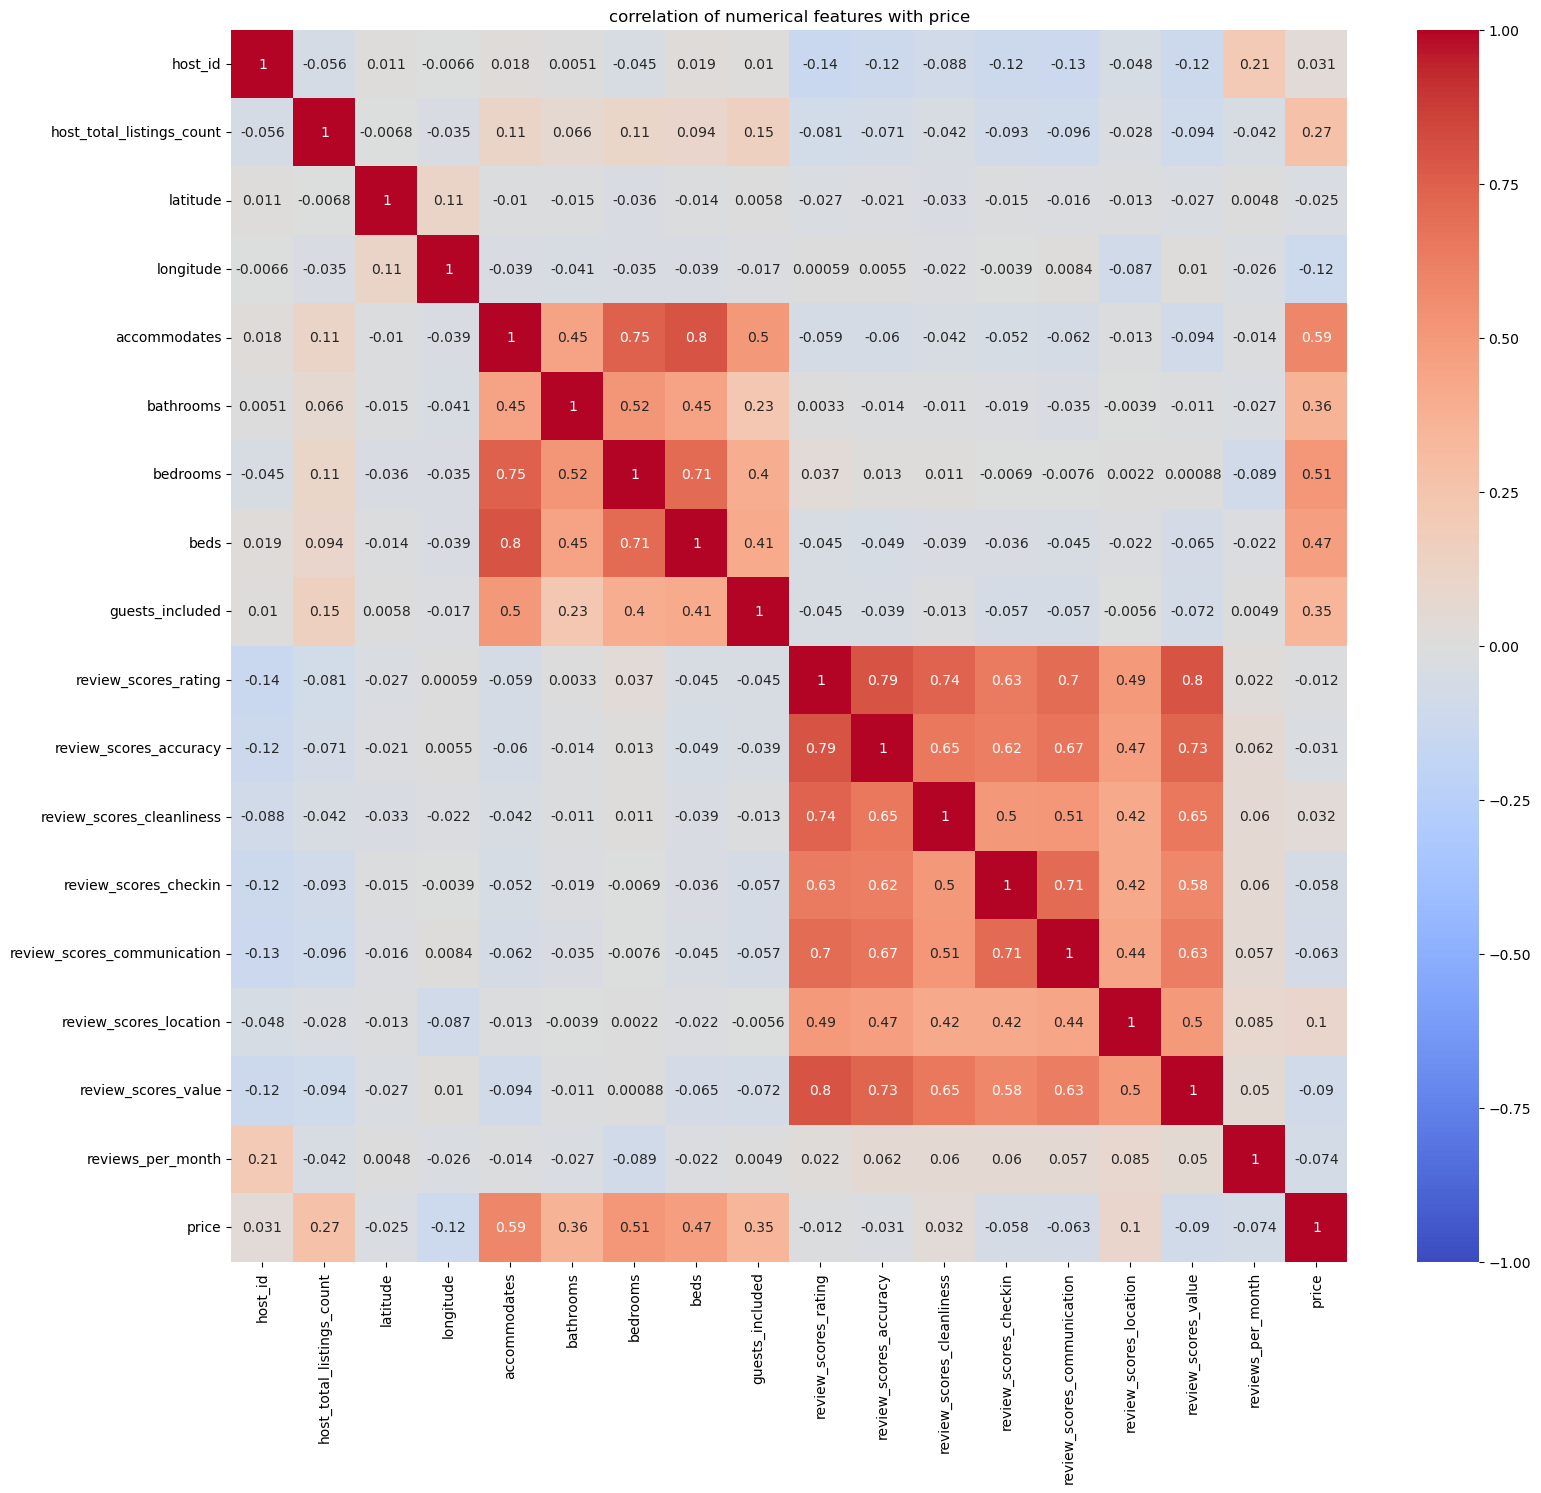

In [252]:
numerical_features = train.select_dtypes(include=['float64', 'int64'])
numerical_features = numerical_features.drop(columns=['price'])
columns = numerical_features.columns.tolist() + ["price"]
correlation_matrix = train[columns].corr()
plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('correlation of numerical features with price')
plt.show()

We notice a wide variety of features in this dataset, consisting of numerical and non-numerical columns. We also discover a range of textual features containing descriptions about different aspects of the listings. 
We also took a glimpse into some correlations as this insight could be important to be espacially cautios to preserve their predictive power when e.g. handling missing values for these features in the next chapter.

### 2.2 Data Type Conversion

At this stage we decide to downcast our numerical features for more efficient memory usage, even though Neural Networks and other complex models typically require features to be stored as floats. We make this decision now to ensure for smoother preprocessing, knowing that we can easily convert these features back when we finalize our model selection.

Its also worth noting that while were making some adjustments to the data types for efficiency, were consciously holding off on more extensive feature engineering, which we will address in a dedicated chapter later. This step is mainly focused on preparing our data for easier handling and setting the stage for missing values.

1. We immediately notice the suboptimal choice of datatype for change host_is_superhost, host_has_profile_pic, and host_identity_verified. We convert them to boolean as they are binary.

2. Non-textual features with a low cardinality get converted into the datatype 'category' to allow for better memory usage. We set the threshold for this to 39 as we decide that property_type marks the threshold for a generl lower cardinality in this dataset. 

In [253]:
# we want to change t&f to 1&0 and save column as boolean
bool_cols = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified']  
for col in bool_cols:
    train[col] = train[col].map({'t': 1, 'f': 0}).astype('bool')


# continue to loop through all categorical features, check cardinality and convert them
threshold = 38
for col in train.select_dtypes(include='object').columns:
    if train[col].nunique() <= threshold:
        train[col] = train[col].astype('category')

3. In our dataset we observe that several columns are of type Float64 even though they dont appear to contain decimal values. To confirm this we check each entry in these columns.

In [254]:
no_floats = []

for col in train.select_dtypes('float64').columns:
    if not all(train[col].dropna().apply(lambda x: x == int(x))):
        print(f"'{col}' contains fractional values.")
    else:
        print(f"'{col}' does not contain fractional values.")
        no_floats.append(col)

'host_total_listings_count' does not contain fractional values.
'latitude' contains fractional values.
'longitude' contains fractional values.
'bathrooms' contains fractional values.
'bedrooms' does not contain fractional values.
'beds' does not contain fractional values.
'price' does not contain fractional values.
'review_scores_rating' does not contain fractional values.
'review_scores_accuracy' does not contain fractional values.
'review_scores_cleanliness' does not contain fractional values.
'review_scores_checkin' does not contain fractional values.
'review_scores_communication' does not contain fractional values.
'review_scores_location' does not contain fractional values.
'review_scores_value' does not contain fractional values.
'reviews_per_month' contains fractional values.


We found that only the 'latitude', 'longitude', 'bathrooms' and 'reviews_per_month' columns contain fractional parts. The use of floats for the latitude and longitude coordinates is standard practice. For the 'reviews_per_month' column, the use of float values is also appropriate, as it likely represents an average value. The presence of fractional values in the 'bathrooms' column may initially seem unusual. However, we assume that within the real estate industry it is common to use fractional values to indicate partial bathrooms. For example, a bathroom withh a toilet and sink but no shower or bathtub is often referred to as a "half bath" and represented with the value of 0.5. Therefore the use of floatingpoint values in this column is reasonable. As we wont be needing the precision of float64, we can convert these columns into float32.

    
We can now proceed to convert the remaining columns to integers. We use the downcast parameter of the to_numeric() function to asses which integer-type to convert to without losing any information. We dont include the host_id as it contains values appropriate for int64.

In [255]:
# add other int64 columns
no_floats.extend(['accommodates', 'guests_included'])

#convert
for col in train.select_dtypes('float64').columns:
    train[col] = train[col].astype('float32')   
    
# do the convertion to nullable Integer 
for col in no_floats: 
    train[col] = train[col].astype('Int32')
    
for col in no_floats:
    train[col] = pd.to_numeric(train[col], downcast='integer')
    print(f"{col}: {train[col].dtype}")

host_total_listings_count: Int16
bedrooms: Int8
beds: Int8
price: Int16
review_scores_rating: Int8
review_scores_accuracy: Int8
review_scores_cleanliness: Int8
review_scores_checkin: Int8
review_scores_communication: Int8
review_scores_location: Int8
review_scores_value: Int8
accommodates: Int8
guests_included: Int8


3. Lastly we look closer into other individual variables. We notice that 'host_since'can be more efficiently saved as date and host_response_rate as a float. 

In [256]:
train['host_since'] = pd.to_datetime(train['host_since'])
train['host_response_rate'] = train['host_response_rate'].str.rstrip('%').astype('float32') / 100.0

For better handling of missing values later, we also label encode host_response_time as an Int8 by noting the ranking from best to worst to 1 to 4. We know that this might establish an ordinal relationship that might not be there, however take this potential bias into account as we will have to change it to a numerical variable later on anyways and find that the trade off here is better than for alternatives like one hot or target encoding 

In [257]:
train['host_response_time'].unique()

['within an hour', 'within a few hours', NaN, 'within a day', 'a few days or more']
Categories (4, object): ['a few days or more', 'within a day', 'within a few hours', 'within an hour']

In [258]:
mapping = {'a few days or more': 4, 'within a day': 3, 'within a few hours': 2, 'within an hour': 1}
train['host_response_time'] = train['host_response_time'].replace(mapping)
train['host_response_time'] = train['host_response_time'].astype('Int8')
print(train[['host_response_time']].head())

   host_response_time
0                   1
1                   2
2                   1
3                   2
4                   1


In [259]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55284 entries, 0 to 55283
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   name                         55270 non-null  object        
 1   summary                      52330 non-null  object        
 2   space                        38403 non-null  object        
 3   description                  53558 non-null  object        
 4   experiences_offered          55284 non-null  category      
 5   neighborhood_overview        35778 non-null  object        
 6   transit                      35477 non-null  object        
 7   house_rules                  31905 non-null  object        
 8   picture_url                  55284 non-null  object        
 9   host_id                      55284 non-null  int64         
 10  host_since                   55173 non-null  datetime64[ns]
 11  host_response_time           37482 non-nu

We notice a decrease of memory usage by ~50%! 

### 2.3 Missing Values 

Firstly, we try to get a better understanding of the missing data

Of 55284 entries, these are the features with missing data, counts and data types:

                             Missing Values       Data Type
name                                     14          object
summary                                2954          object
space                                 16881          object
description                            1726          object
neighborhood_overview                 19506          object
transit                               19807          object
house_rules                           23379          object
host_since                              111  datetime64[ns]
host_response_time                    17802            Int8
host_response_rate                    17802         float32
host_total_listings_count               111           Int16
neighbourhood                           147          object
zipcode                                1272          object
bathrooms                                70         float32
bedrooms        

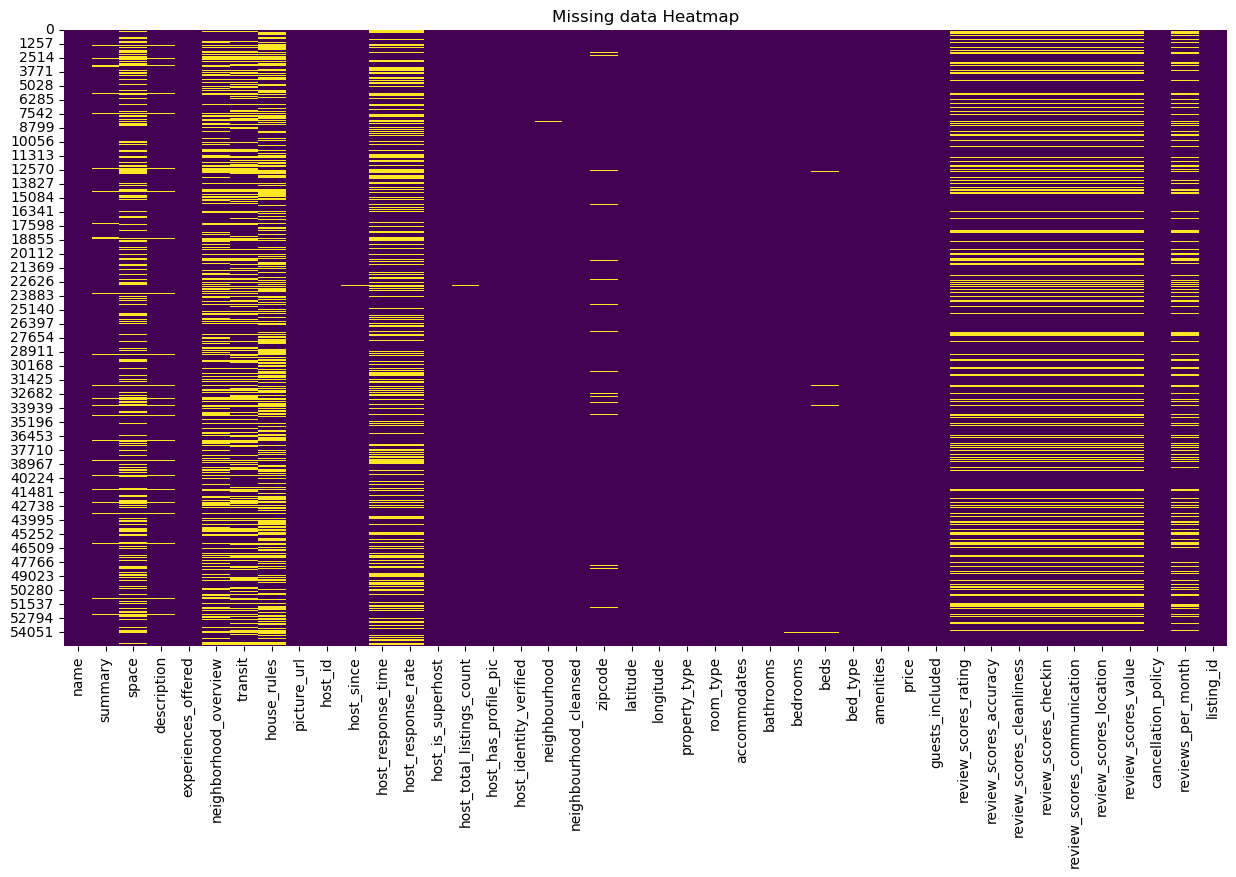

In [260]:
missing_data = train.isnull().sum()
columns_with_missing_data = missing_data[missing_data > 0]

missing_data_train = pd.DataFrame({'Missing Values': columns_with_missing_data})
missing_data_train['Data Type'] = train[missing_data_train.index].dtypes

print("Of 55284 entries, these are the features with missing data, counts and data types:")
print()
print(missing_data_train)
print()
plt.figure(figsize=(15, 8))
sns.heatmap(train.isnull(), cbar=False, cmap='viridis')

# Display the heatmap
plt.title('Missing data Heatmap')
plt.show()

We notice that across many features, theres a substantial amount of missing data. We try to think about the underlying reasons why this data could be missing and dig deeper into the domain of AirBnB. 
Our dataset is made up of property listings where its reasonable to assume that features such as 'summary', 'transit' and 'house_rules' contain information provided by property owners. Naturally, these owners tend to emphasize the positive aspects of their properties while potentially downplaying or leaving out any negative aspects. In handling missing values within this context its crucial to be cautious and recognize that the absence of information might have intentional reasons.

Its essential to keep this contextual information when dealing with missing values. We can still drop them or entirely remove weak features after evaluating their predictive power.


We decide that the absence of values of the categorical columns 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'transit', 'house_rules', 'neighbourhood' and 'zip_code' could potentially hold predictive power. We replace Missing values with "not provided".

In [261]:
missing_cols_1 = ['name', 'summary', 'space', 'description', 'neighborhood_overview',
                   'transit', 'house_rules', 'neighbourhood', 'zipcode']

for col in missing_cols_1:
    train[col] = train[col].fillna('not provided')

The missing values for the numerical columns 'bathrooms,' 'bedrooms,' 'beds,' 'host_total_listings_count,' as well as the two 'host_response' and eight 'review' features could also hold predictive power. While most of this information may not be provided by the property owner, except for the first three, the absence of for example 'response times' and 'reviews' could be an indicator of bad property owners that come with characteristic prices. 

We choose to mark the missing values here as well. To achieve this, we need to add another binary column for each of these columns to mark the missing values. However, this approach comes with the problemof further increasing the complexity of the model by 14 additional columns

Therefore, due to the significantly low number of missing values in 'bathrooms,' 'bedrooms,' 'beds,' and 'host_total_listings_count,' we decide not to use indicator columns for these and just apply them to the two 'host_response' and eight 'review' features. Additionally, from the heatmap used earlier we can observe that when values are missing for the 'host_response' and 'review' features, none of the features in that group have values. We will investigate this further to confirm. 

In [262]:
host_response_cols = ['host_response_time', 'host_response_rate']
review_cols = [ 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                'review_scores_communication', 'review_scores_location', 'review_scores_value','reviews_per_month']

host_response_missing = train[host_response_cols].isnull().all(axis=1)
review_missing = train[review_cols].isnull().all(axis=1)

# Count the entries where all features in each group are missing
host_response_missing_count = host_response_missing.sum()
review_missing_count = review_missing.sum()

print(f'Entries where all host_response features are missing: {host_response_missing_count}')
print(f'Entries where all review features are missing: {review_missing_count}')

Entries where all host_response features are missing: 17802
Entries where all review features are missing: 12379


We see that for the host_response features this is true for all entries and for the review features its true for the vast majority. We now decide to encode the missing values in two feature groups by creating two binary columns. 
We finally replace the missing values in the features by either with the mean or median, based on skewness. 

In [263]:
# create columns and let entry be true if all features in the either the host_response or review group are missing
for group, group_name in [(host_response_cols, 'host_response_missing'), (review_cols, 'review_missing')]:
    missing_sum = train[group].isnull().sum(axis=1)
    train[group_name] = (missing_sum == len(group)).astype(int)

cols = host_response_cols + review_cols
# impute missing values 
for col in cols:
    if col in train.select_dtypes(include=[np.number]).columns:
        if abs(train[col].skew()) > 1:
            median_value = train[col].median()
            train[col] = train[col].fillna(median_value)
        else:
            mean_value = train[col].mean()
            train[col] = train[col].fillna(mean_value)

The remaining columns are beds, bedrooms, bathrooms, host_total_listings_count, host_since. Above we already explained why theres no special treatment for the first four. host_since didnt end up in missing_cols_1, as its not reasonable to assume this information was provided by the property owner but more likely from the AirBnB plattform system. 
We replace all of these missing values with the median/average or mode and dont worry about any underlying information in the missing values as there are so few in these features. It is unlikely to significantly impact our analysis.

In [264]:
missing_cols_2 = ['host_total_listings_count', 'bathrooms', 'bedrooms', 'beds']

# figure out if data is skewed and replace with median or mean appropriately 
for col in missing_cols_2:
    if abs(train[col].skew()) > 1:  
        median_value = train[col].median()
        train[col] = train[col].fillna(median_value) 
    else:
        mean_value = train[col].mean()
        train[col] = train[col].fillna(mean_value)

# replace NA in host_since with mode 
mode_value = train['host_since'].mode()[0]
train['host_since'] = train['host_since'].fillna(mode_value) # Replace with mode

In [265]:
total_missing_values = train.isnull().sum().sum()
print(f'Total missing values in the dataset: {total_missing_values}')

Total missing values in the dataset: 0


### 2.4 Text Cleaning

Before we leave our cleaning chapter, we still need to look into an inportant "cleaning" job in our data that we have not yet considered: The cleaning of our textual features for further analysis. As a first step, we get to know our textual features in depth

In [266]:
pd.set_option('display.max_colwidth', None)
textual_features = ['name', 'summary', 'space', 'description', 
    'neighborhood_overview', 'transit', 'house_rules', 'amenities']

In [267]:
for feature in textual_features:
    print(f"\n{feature}:")

    # Examine text length
    text_length = train[feature].dropna().apply(len)
    print(f"Average text length: {text_length.mean():.2f}")
    print(f"Minimum text length: {text_length.min()}")
    print(f"Maximum text length: {text_length.max()}")
    
    # Identify special characters and numbers
    special_chars = train[feature].dropna().apply(lambda x: ''.join(char for char in x if not char.isalnum() and not char.isspace()))
    unique_special_chars = ''.join(set(''.join(special_chars)))
    print(f"Unique special characters: {unique_special_chars}")
    
    # Identify numbers
    numbers = train[feature].dropna().apply(lambda x: ''.join(char for char in x if char.isdigit()))
    unique_numbers = ''.join(set(''.join(numbers)))
    print(f"Unique numbers: {unique_numbers}")


name:
Average text length: 38.83
Minimum text length: 1
Maximum text length: 255
Unique special characters: ´%-️❈”(♛☼|)◄"№➽✈❀☆⚘&¥™_@:⭐✅►❥､☘⚡￨♣♥♡】⫸.✮\☀{;★£‘®➔❣…+✪—⋙✨#･∞^●/☛=➕❢￫⋘!｡*°•♠☕❤’✯],【✧[‑☞–>`·}“⫷?~'✩<
Unique numbers: 156₆¹4₄₂9₈30₁2³²87

summary:
Average text length: 326.64
Minimum text length: 1
Maximum text length: 1000
Unique special characters: ´♀%⚪-️☺”(♛|)"✈☆‬¡&_‍@:￬⭐✅✓×》､♣♥″♡】.­‏\﻿{;£‘★®❣⋯€¬…《+‣—✨#･^●➡/=$‭➕¦￫!｡㎡*°✔′•☕⚠❤’],【[‪※©✴‑￮»–♦>`·}“?~₤¨'¢<
Unique numbers: 51649302²87

space:
Average text length: 335.11
Minimum text length: 1
Maximum text length: 1000
Unique special characters: ́´%-️☺∙︎”(|)"☆▪‬&™_‍@:⭐✅►✓×》､❗✬♥″♡】√.­\﻿{☀;£‘★®€¬…+✪—#^●/«=$￫!｡*°✔′•‐☕❤’✯],【⁃[̓‪≈‑»–♦>✌`➖·}“?~₤¨'🛁⚫✩<
Unique numbers: 15649302²87

description:
Average text length: 769.96
Minimum text length: 1
Maximum text length: 1000
Unique special characters: ́´♀%⚪-️☺∙︎”(♛|)"˜✈☆▪‬¡&™_‍@:￬⭐✅►✓×》､❗✬♣♥″♡】√.­‏\﻿{☀;£‘★®❣⋯€¬…《+‣✪—✨⯁#･❌⭕^●➡/«=$‭➕¦￫!｡㎡*°✔′•‐⚽☕⚠❤’✯],【⁃[̓‪※≈©‑✴￮»–♦>✌`➖·}“?~₤✆¨'🛁⚫¢<
Unique numbers: 516

Based on our embedding choice later in our pipeline, we decide to clean the text doing the following: 
    
    1. Replacing numbers with <NUM>, specific characters with words, and other special symbols that we evaluated as possibiliy carrying important information in the context of AirBnB listings with individual placeholders, while other symbols get <SPECIAL>. This helps in reducing the complexity of the text and retaining some semantic meaning.

    2. Converting all characters to lowercase 
    
    3. removing excess whitespace.

    4. lemmatize 
    
    5. remove stopwords 
    
    6. bring 'Amenities' into the same format as the other textual features 


In [ ]:
#nltk.download('stopwords')

# Stopwords
stop_words = set(stopwords.words('english')
                )
lemmatizer = WordNetLemmatizer()

# Function to clean text
def clean_text(text):
    # Convert numbers to <NUM> placeholder
    text = re.sub(r'\d+', '<NUM>', text)

    # Do same for chosen special symbols 
    text = text.replace('.', ' <DOT> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('$', ' <DOLLAR> ')
    text = text.replace('£', ' <POUND> ')
    text = text.replace('€', ' <EURO> ')
    text = text.replace('%', ' <PERCENT> ')
    text = text.replace('#', ' <HASHTAG> ')
    text = text.replace('*', ' <ASTERISK> ')
    text = text.replace('!', ' <EXCLAMATION> ')
    text = text.replace('✅', ' <CHECK_MARK> ')
    text = text.replace('❤', ' <HEART> ')
    text = text.replace('☆', ' <STAR> ')
    text = text.replace('⭐', ' <STAR> ')
    text = text.replace('™', ' <TRADEMARK> ')
    text = text.replace('✈', ' <AIRPLANE> ')
    text = text.replace('⚠', ' <WARNING> ')
    text = text.replace('✔', ' <CHECK> ')
    text = text.replace('°', ' <DEGREE> ')
    text = text.replace('♡', ' <LOVE> ')
    
    # Replace other special symbols with <SPECIAL>
    special_chars = re.compile('[^A-Za-z0-9 <DOT> <COMMA> <DOLLAR> <POUND> <EURO> <PERCENT> <HASHTAG> <ASTERISK> <EXCLAMATION> <CHECK_MARK> <HEART> <STAR> <TRADEMARK> <AIRPLANE> <WARNING> <CHECK> <DEGREE> <LOVE> ,.!?]+')
    text = special_chars.sub(' <SPECIAL> ', text)

    # Convert to lowercase
    text = text.lower()

    # Remove stop words
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    # lemmatize 
    words = [lemmatizer.lemmatize(word) for word in words]

    text = ' '.join(words)

    # Remove excess whitespace
    text = re.sub(' +', ' ', text).strip()

    return text

# Bring amenitites into same shape as other textual features 
train['amenities'] = train['amenities'].apply(lambda x: x.replace('{', '').replace('}', '').replace('"', ''))

for feature in textual_features:
    train[feature] = train[feature].apply(clean_text)

In [ ]:
train[textual_features].head(5)

## 3. EDA

In this chapter we will be taking a birdseye perspective to try to find and understand important patterns in the data.  We start off by examining our target.

### 3.1  Target Distribution (Price)

In [ ]:
price = train['price']

# Plotting a histogram
plt.figure(figsize=(18, 6))  
plt.hist(price, bins=50, color='red', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Number of Listings')
plt.title('Distribution of Listing Prices')
plt.show()

print('Mean:', price.mean())
print('Median:', price.median())
print('Standard Deviation:', price.std())

skewness = price.skew()
print('Skewness:', skewness)

We have observed that our target variable, price, is skewed. This means that there are a few very high prices that might affect our analysis.
We remember this skewdness as it will most likely lead to a bias within the prediction for the higher target values. 

In [ ]:
# Plotting a boxplot 
plt.figure(figsize=(18, 6))  
sns.boxplot(x=price, color='blue') 
plt.xlabel('Price')
plt.title('Boxplot of Listing Prices')
plt.show()

Q1 = price.quantile(0.25)
Q3 = price.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = price[(price < lower_bound) | (price > upper_bound)]
print('Number of Outliers:', len(outliers))


Upon examining the boxplot we do notice the presence of upper outliers. In the context of property listings these outliers actually represent more expensive properties. Given their even distribution they can provide valuable insights into price variation. Therefore, we decide to retain them in our dataset.

### 3.2 Numerical Features 

Going forward, we distinguish the different groups of features that require different EDA approaches.
After a first inital partition we find 23 numeric columns.

In [ ]:
numerical_features = ['host_response_rate', 'host_response_time', 'host_total_listings_count', 'latitude', 'longitude', 
    'accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
    'review_scores_value', 'reviews_per_month', 'host_response_missing', 'review_missing', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified']

As for the 19 remaining columns, we have
- 8 high cardinality columns that hold textual information as well as 
- 7 non-text low cardinality columns. 
- 4 left over features that dont fit into any of the groups 

In [ ]:
textual_features = ['name', 'summary', 'space', 'description', 
    'neighborhood_overview', 'transit', 'house_rules', 'amenities']

non_numerical_features = [ 
    'experiences_offered', 'neighbourhood', 'neighbourhood_cleansed','cancellation_policy',
    'property_type', 'room_type', 'bed_type']

left_over_features = ['listing_id','host_id','picture_url', 'host_since']

Regarding the left_over_features, we choose to disregard "listing_id" and "host_id." The former serves as a unique identifier in the dataset, while the latter is redundant given that we already have "host_total_listings_count" to capture any predictive power it might offer. As for 'picture_url' and 'host_since,' we will get to them later in our analysis pipeline.

We noq proceed to look at correlations between our numerical features and the target with a heatmap and the Spearman rank correlation. We take note of significant correlations that match in both correlation methods. 

In [ ]:
correlation_matrix = train[numerical_features + ["price"]].corr()
plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation heatmap of numerical features with price')
plt.show()

We observe the following linear corrleations 
1. strong positive correlations for accommodates, bathrooms, bedroms, beds, guests_included and host_total_listings_count  
2. moderate positive correlation with review_scores_location and review_missing. 
3. moderate negative correlation with longitude and host_response_missing

In [ ]:
correlations = []
for feature in numerical_features:
    coef, p = spearmanr(train[feature], train['price'])
    correlations.append((feature, coef))

corr_df = pd.DataFrame(correlations, columns=['Feature', 'Spearman Correlation'])
print(corr_df.sort_values(by='Spearman Correlation', ascending=False))

To this list, we add: 

4. moderate negative correlation with host_response_rate and review_scores_valeúe

Moving ahead, we employ further data visualization techniques to gain an even better understanding of our features.

In [ ]:
train[numerical_features].hist(figsize=(15,12))
plt.show()

In [ ]:
# Pearson correlation 
interaction_df = pd.DataFrame()
for i, feature1 in enumerate(numerical_features):
    for j, feature2 in enumerate(numerical_features):
        if i >= j:
            continue 
        interaction_term = f"{feature1}_x_{feature2}"
        interaction_df[interaction_term] = train[feature1] * train[feature2]


interaction_df['price'] = train['price']
correlation_with_target = interaction_df.corr()['price'].sort_values(ascending=False)
print(correlation_with_target)

We get a feeling for the relevance of the features and will keep this in mind as we go on.

### 3.3 Non-Numerical Features

In [ ]:
for feature in non_numerical_features:
    plt.figure(figsize=(18, 9))
    train[feature].value_counts().plot(kind='bar')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

While Chi-Square tests are a compelling option for analyzing the relationship between our categorical features and the target, we have concerns about meeting the criteria for minimum expected frequency in each feature category.

In [ ]:
for feature in non_numerical_features:
    # create a contingency table for the feature
    contingency = pd.crosstab(train[feature], train[feature])
    
    # calculate the expected frequencies
    chi2, p, dof, expected = chi2_contingency(contingency, correction=False)
    
    # print the minimum expected frequency
    print(f"Minimum expected frequency for {feature}: {expected.min()}")

As its under the recommended threshold of 5 for all features, chi square could be unreliable here. We decide to create more heatmaps, by dummy encoding all the categories and then plotting them against the target. We will look at 'zipcode' and 'neighboorhod' after weve performed feature engineering on them as it would not be possible ot look at their correlation this way. 

In [ ]:
# Seperate high level count features into their own heatmaps
individual_features = ['neighbourhood_cleansed', 'property_type']
combined_features =[ 'experiences_offered' ,'cancellation_policy', 'room_type', 'bed_type']

# display heatmap with this
def display_heatmap(dataframe, title):
    correlation_matrix = dataframe.corr()
    plt.figure(figsize=(35, 35))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(title)
    plt.show()

# heatmap for combined features
dummy_combined = pd.get_dummies(train[combined_features])
dummy_combined['price'] = train['price']
display_heatmap(dummy_combined, 'Combined Features Heatmap')

# heatmap for individual features
for feature in individual_features:
    dummy_individual = pd.get_dummies(train[feature])
    dummy_individual['price'] = train['price']
    display_heatmap(dummy_individual, f'{feature} Heatmap')

Of course we have to be a bit careful when talking about how well these features relate to our target. It's not as straightforward as it is with the numerical ones.

The following linear relationships can be seen in these plots:
- cancellation_policy: moderate positive for cancellation policy strict 14_with grace period and moderate negative for cancellation_policy_flexible 
- room_type: strong positive for room type Entire home/apt and strong negative for room type private room
- neighborhood _cleansed: moderate positive for Kingston and Chelsea as well as Westminster. 
- zipcode: moderate positive for SW, W, WC as wwell as moderate negative for greater london area, E, SE

We also notice no significant linear relationships for the levels of the features: 
- experiences offered
- bed_type 
- property_type

### 3.4 Textual Features 

Next up we try to get an intuition for the relationship between our textual features and the target. Analyzing the relationship between textual features and a target variable is challenging due to the high dimensionality of text data and the often qualitative nature of text content. We try to look at some interesting statistics like sequence length or unique word count and also make an attempt of showing correlation with the target. We specifically look at the sequence length, number of words and unique words. 

In [ ]:
train[textual_features].head(1)

In [ ]:
# DataFrame to hold our textual-EDA results
textual_eda = pd.DataFrame()

# Loop through each textual feature and calculate various statistics
for feature in textual_features:
    col_data = train[feature]
    
    #'not provided' Count
    not_provided_count = col_data[col_data.str.lower() == 'not provided'].count()
    
    # average sequence length
    avg_seq_length = col_data.apply(len).mean()
    
    # average number of words
    avg_num_words = col_data.apply(lambda x: len(str(x).split())).mean()
    
    # average number of unique words
    avg_num_unique_words = col_data.apply(lambda x: len(set(str(x).split()))).mean()
    

    textual_eda[feature] = [not_provided_count, avg_seq_length, avg_num_words, avg_num_unique_words]
    
textual_eda.index = ['Not Provided Count', 'Average Sequence Length', 'Average Number of Words', 'Average Number of Unique Words']
print(textual_eda)

In [274]:
# Compute correlation matrix
temp_df['price'] = train['price']
correlation_matrix = temp_df.corr()
correlation_with_price = correlation_matrix['price']
correlation_with_price = correlation_with_price.sort_values(ascending=False)
print(correlation_with_price)

price                                     1.000000
space_seq_len                             0.194860
space_num_words                           0.185455
space_num_unique_words                    0.175011
neighborhood_overview_seq_len             0.139716
amenities_seq_len                         0.135907
neighborhood_overview_num_unique_words    0.132952
neighborhood_overview_num_words           0.131839
description_seq_len                       0.102996
name_seq_len                              0.095117
amenities_num_unique_words                0.090687
house_rules_num_unique_words              0.090556
house_rules_seq_len                       0.089734
house_rules_num_words                     0.086709
amenities_num_words                       0.083695
description_num_words                     0.076705
description_num_unique_words              0.074706
name_num_words                            0.061430
name_num_unique_words                     0.057886
summary_seq_len                

We know that correlation doesnt imply causation, espacially in the context of textual data, these are very simplistic metrics. These Metrics however give us the first impression that our textual data has a moderate to weak correlation with our target. We will include this in our final model decision. 

## 4. Feature Engineering
### 4.1 Transformations 

Now that we got a better intuition of our data, we will now be paying attention to some features within these groups and further refine them. 

Starting off, we adress feature host_since, which we left out of our initial partioning as we converted it to the datetime datatype and thus it doesnt exactly fit it into any of the groups. We could keep it as its own category, however our intuition tells us that seasonality probabily wont be impacting the target and everything except the year will have very little impact. In this case, we could turn host_since into an integer. We further investigate this to be sure:

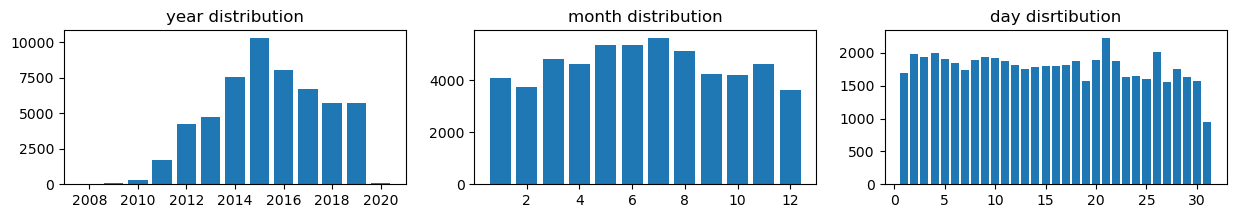

year     0.019701
month   -0.000857
day      0.006766
Name: price, dtype: float64


In [36]:
# extract year, nonth and date 
train['year'] = train['host_since'].dt.year
train['month'] = train['host_since'].dt.month
train['day'] = train['host_since'].dt.day

#plot their distribution
fig, axs = plt.subplots(1, 3, figsize=(15, 2))
axs[0].bar(train['year'].value_counts().sort_index().index, train['year'].value_counts().sort_index().values)
axs[0].set_title('year distribution')
axs[1].bar(train['month'].value_counts().sort_index().index, train['month'].value_counts().sort_index().values)
axs[1].set_title('month distribution')
axs[2].bar(train['day'].value_counts().sort_index().index, train['day'].value_counts().sort_index().values)
axs[2].set_title('day disrtibution')
plt.show()

#print correlation with price
correlation_with_target = train[['year', 'month', 'day', 'price']].corr()['price'][:-1]
print(correlation_with_target)

train.drop(['year', 'month', 'day'], axis=1, inplace=True)

Our analysis of the distribution plots and correlation metrics suggests that months and days have an insignificant or very weak linear relationship with our target variable. As a result, we decide to simplify our feature set by only retaining the year information.

Moreover, we transform the year into a more machine learning friendly format by representing it as the number of years since registration, with values ranging from 0 to 12.

In [37]:
# Extract the year, transform to 0-12 range 
train['host_since_year'] = train['host_since'].dt.year.astype('Int16')
train['years_since_registration'] = train['host_since_year'].max() - train['host_since_year'] + 1

# Drop 'host_since' and 'host_since_year' and add 'years_since_registration' to our list of numerical features
train.drop(['host_since', 'host_since_year'], axis=1, inplace=True)
numerical_features.append('years_since_registration')
print(train['years_since_registration'].head(5))

0    9
1    7
2    2
3    9
4    5
Name: years_since_registration, dtype: Int16


Next up is 'zipcode'. We notice the high count for unique values of 25000. When considering the context, this seems highly unusual: London, being a city, would not have anywhere near 25000 unique  zipcodes. To put this into perspective, the entire country of Germany has approximately 8000 unique zipcodes. We investigate this further by looking at the unique values and frequencies 

In [39]:
# Display unique zipcoces and the top ZIP codes by frequency
unique_zipcodes = train['zipcode'].unique()
print(unique_zipcodes[:100]) 
print()
print(train['zipcode'].value_counts().head(20)) 

['SE10 8SX' 'N8 8NR' 'SW19 1DG' 'SW4 9EF' 'SE11 5TL' 'SE8 5AW' 'W5 5ED'
 'E1 2QZ' 'UB3 4QY' 'SW8 4HJ' 'SW4 6FE' 'N7' 'SE22' 'E1 8LY' 'N7 0NN'
 'SE24' 'SW19' 'SW3 4RD' 'NW6 1BP' 'N4 3JJ' 'SW2 2QP' 'E1 0DN' 'SE15 6DX'
 'SW1V 4RZ' 'WC1N 1DF' 'SE1 1YZ' 'SW8 1DL' 'N5 1GE' 'SE15' 'NW6 2BY'
 'SE26' 'N4 3HZ' 'SE13 5AG' 'SE5 0PW' 'E2 6DG' 'SW8 4BG' 'E17 7DN'
 'W1W 8NQ' 'N5 2UU' 'E1 4GJ' 'E15 3EW' 'E8 1BZ' 'WC1H 8JP' 'not provided'
 'N1 1PA' 'SE24 9AF' 'SW5 9SG' 'W6' 'TW7 4LE' 'NW6 6AE' 'N1' 'SE1 3GN'
 'W10 4LG' 'E8 1EY' 'NW1 2HL' 'RM7 8AQ' 'W1T 4HJ' 'E16 1YH' 'N16'
 'KT2 6LG' 'NW11 7HF' 'SE17 1GG' 'SW1V 3EN' 'NW4' 'W12 9DR' 'E14' 'E5'
 'TW14 0NB' 'SE7 7BZ' 'N16 7NX' 'W12 9HW' 'W2 2YE' 'E1 6SY' 'W7' 'E8'
 'W12 9SH' 'HA0 4UY' 'E1' 'W4 1EX' 'SW1Y4UF' 'E8 3EP' 'E17 4PX' 'N11 1EH'
 'SW5 9RH' 'N7 8TP' 'E7 9HF' 'SE13 7TT' 'NW8 0NG' 'E14 2DA' 'E14 7HG'
 'N16 8AP' 'E2 0AA' 'WC1X 9AE' 'N1 7GS' 'W9 2JE' 'SE15 1AJ' 'N7 0RA'
 'SE1 8TG' 'SW8 1XT' 'NW2']

zipcode
not provided    1272
E1               292
NW1 

This gives an interesting insight into the UKs zip code system. It is designed to be very precise and efficent for sorting mails etc. However, considering our existing geographical features, longitude, latitude, and the cleaned neighborhood column, we find that our dataset already provides a fine level of granularity in representing locations. 

By retaining only the first part of the zipcode, we will be left with a number distinct areas.
After conducting research on London's postal code system, we have identified that the city is divided into eight distinct postal code areas ('EC', 'WC', 'E', 'SE', 'SW', 'W', 'NW', 'N'). To avoid adding excessive categories to our analysis, we have decided to relate the remaining postal codes corresponding to the Greater London area ('EN', 'HA', 'UB', 'IG', 'KT', 'TW', 'CR', 'BR', 'SM', 'RM', 'DA', 'SL') and put them into a single group labeled 'greater london area'. Any other entry will be categorized under 'not provided'. 
 
This approach should complement our existing geographical features without adding unnecessary complexity.

In [40]:
# Define a function to extract the postcode area
def get_postcode_area(zipcode):
    london_area = ['EC', 'WC', 'E', 'SE', 'SW', 'W', 'NW', 'N']
    greater_london_area = ['EN', 'HA', 'UB', 'IG', 'KT', 'TW', 'CR', 'BR', 'SM', 'RM', 'DA', 'SL']
    all_areas = london_area + greater_london_area
    
    #remove non-letters from beginning
    zipcode = re.sub('^[^a-zA-Z]+', '', zipcode) 
    zipcode = zipcode.upper() # make sure all are uppercase
    for area in all_areas:
        if area in london_area and zipcode.startswith(area):
            return area
        elif area in greater_london_area and zipcode.startswith(area):
            return 'greater london area'
    return 'not provided'

# Apply function 
train['zipcode'] = train['zipcode'].apply(get_postcode_area)

zipcode_counts = train['zipcode'].value_counts()
print(zipcode_counts)
non_numerical_features.append('zipcode')

zipcode
E                      10370
SW                     10008
W                       8336
N                       7494
SE                      6854
NW                      5170
greater london area     4705
WC                      1269
EC                      1060
not provided              18
Name: count, dtype: int64


As mentioned above, we also plot a heatmap for zipcode and notice a moderate positive for SW, W and WC as well as moderate negative for greater london area, E and SE.


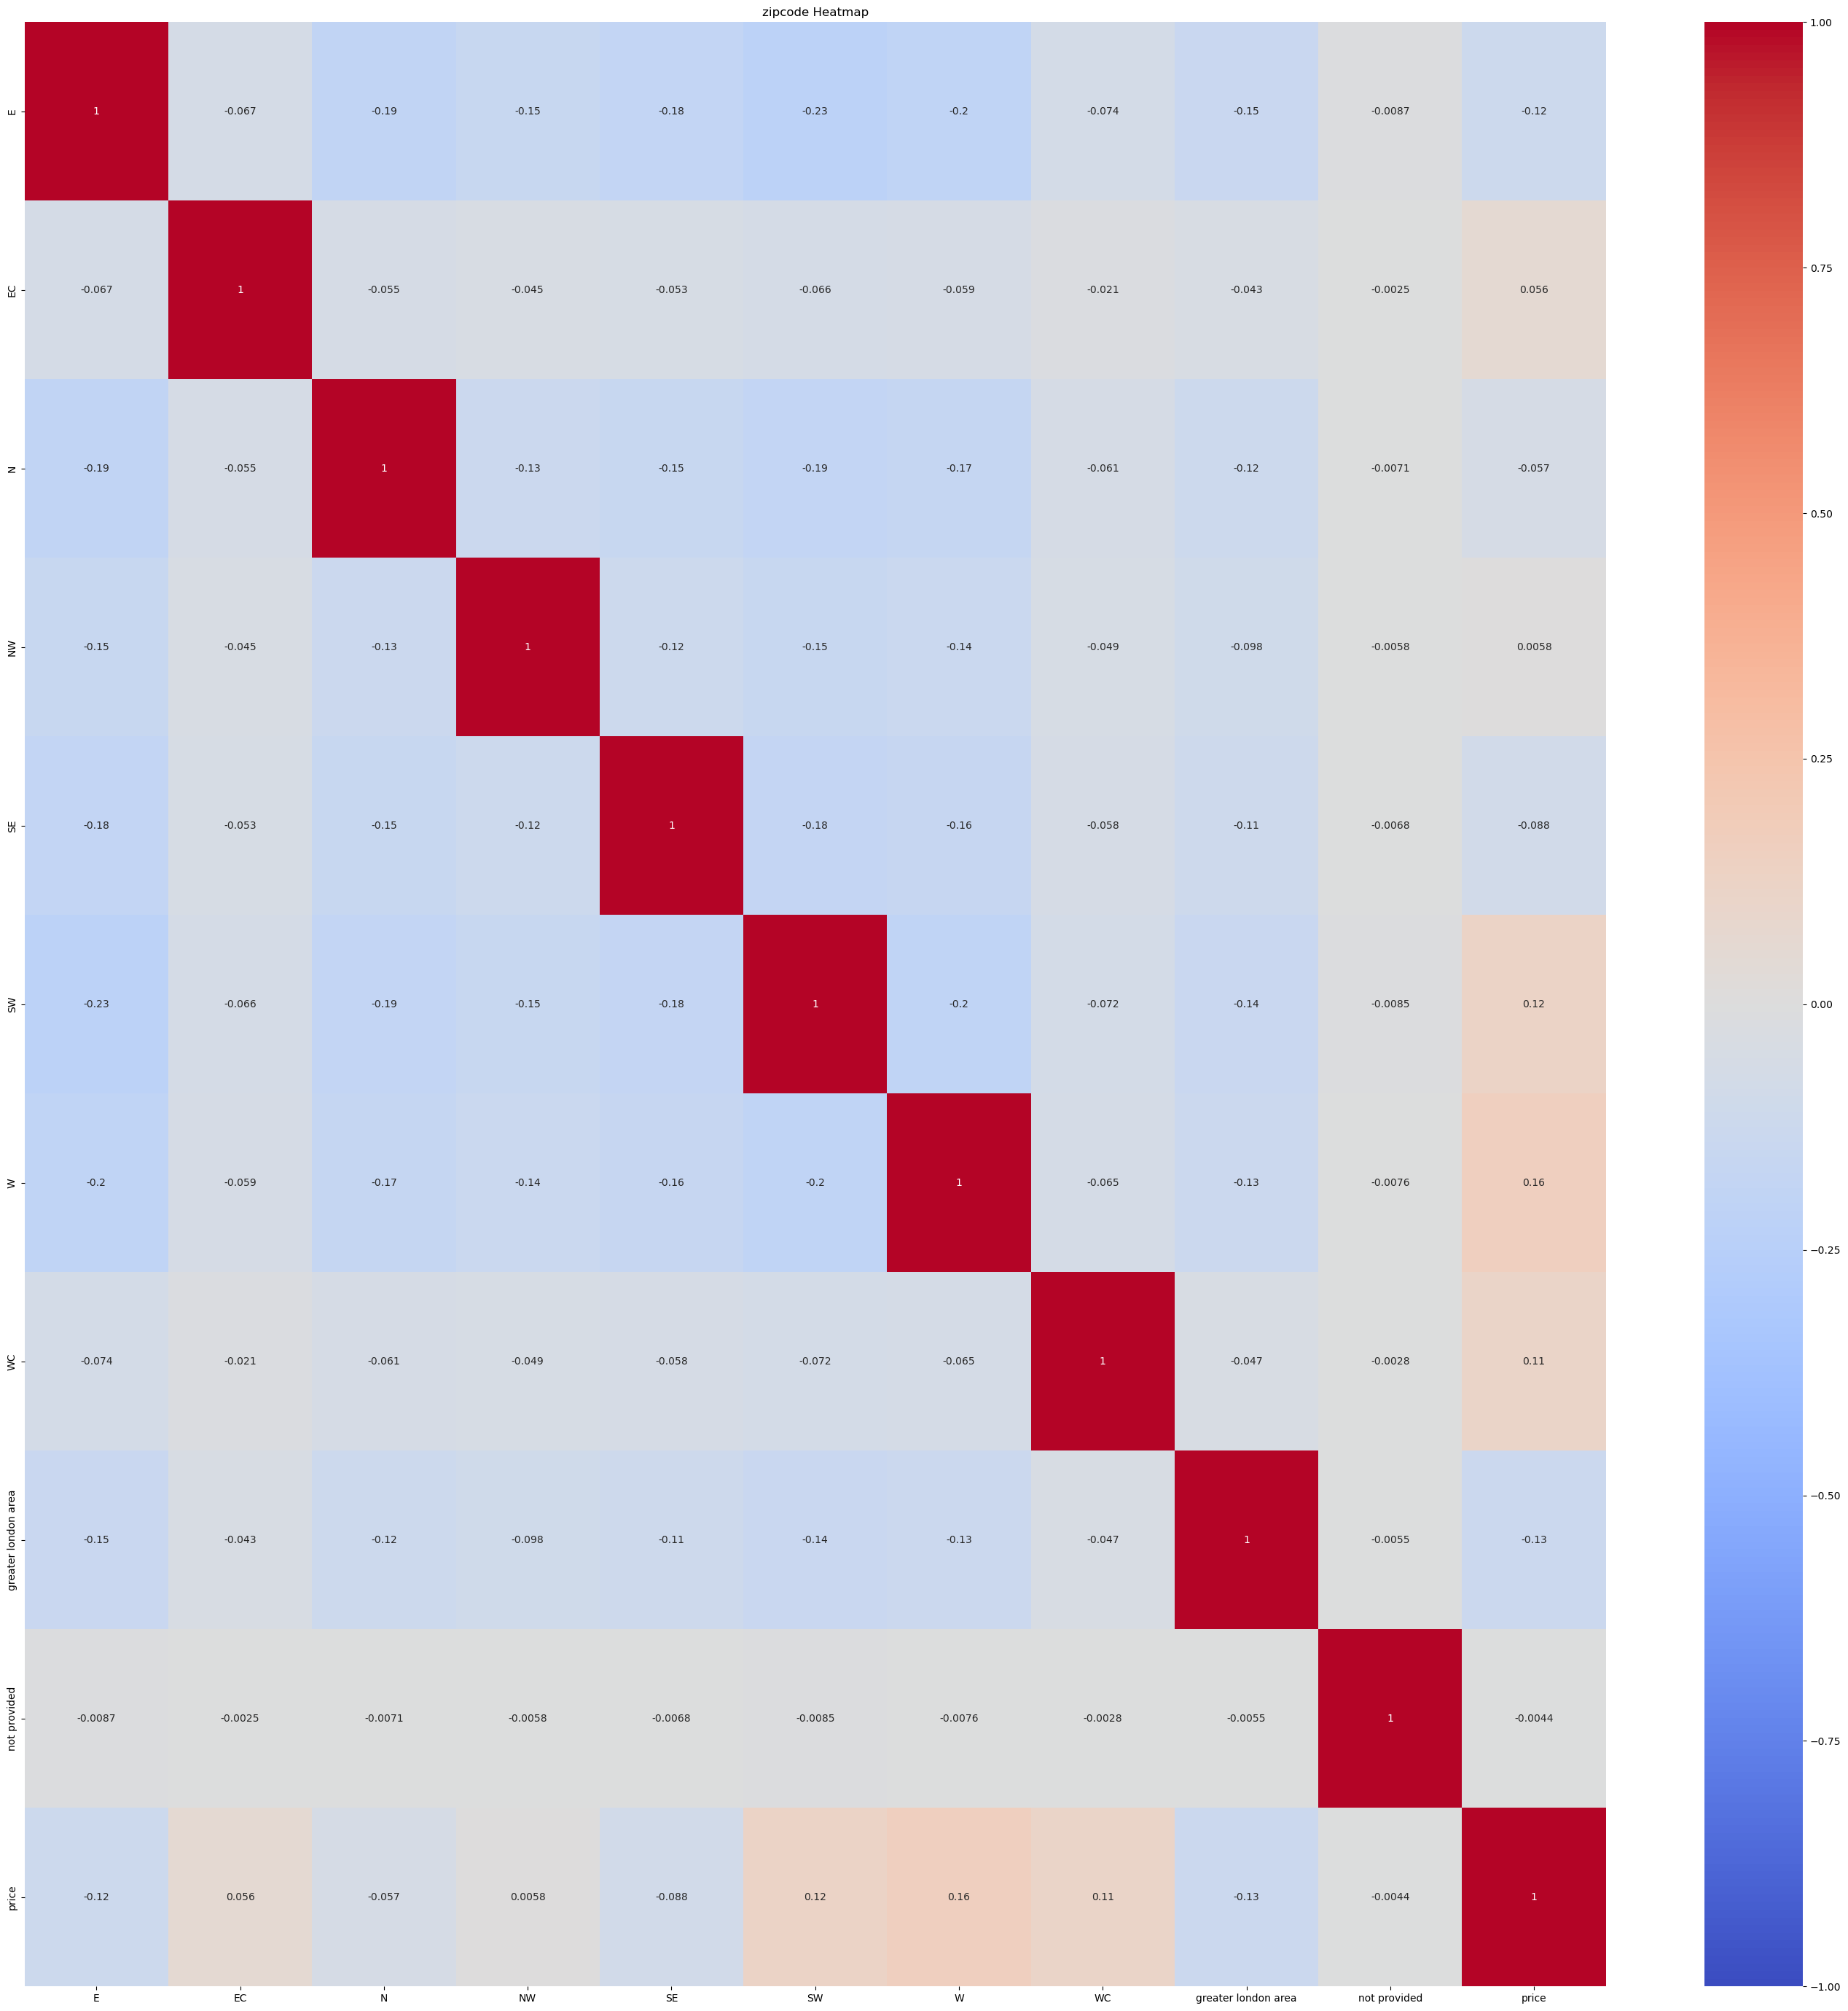

In [41]:
individual_features = ['zipcode'] 
for feature in individual_features:
    dummy_individual = pd.get_dummies(train[feature])
    dummy_individual['price'] = train['price']
    display_heatmap(dummy_individual, f'{feature} Heatmap')

Now that we have cleansed our zip_codes we notice the already cleaned 'neighbourhood_cleansed' and its similarity to the 'neighbourhood' column.

In [42]:
comparison_df = train[['neighbourhood', 'neighbourhood_cleansed']].copy()
print(comparison_df.head(10))

            neighbourhood neighbourhood_cleansed
0               Greenwich              Greenwich
1          LB of Haringey               Haringey
2            LB of Merton                 Merton
3                 Clapham                Lambeth
4           LB of Lambeth                Lambeth
5         LB of Southwark              Southwark
6            LB of Ealing                 Ealing
7  Whitechapel/Brick Lane          Tower Hamlets
8        LB of Hillingdon             Hillingdon
9        LB of Wandsworth             Wandsworth


To further investigate this we take a look at their unique values

In [43]:
neighbourhood_values = train['neighbourhood'].value_counts()
neighbourhood_cleansed_values = train['neighbourhood_cleansed'].value_counts()

print("Neighbourhood values:\n", neighbourhood_values)
print("\nNeighbourhood_cleansed values:\n", neighbourhood_cleansed_values)

Neighbourhood values:
 neighbourhood
City of Westminster             3292
LB of Tower Hamlets             2912
LB of Hackney                   2547
LB of Islington                 2407
LB of Camden                    2062
LB of Brent                     1610
RB of Kensington and Chelsea    1596
LB of Southwark                 1584
LB of Lambeth                   1561
LB of Wandsworth                1520
LB of Haringey                  1415
LB of Hammersmith & Fulham      1300
LB of Newham                    1193
LB of Barnet                    1101
LB of Waltham Forest             969
RB of Greenwich                  952
LB of Ealing                     872
LB of Lewisham                   819
LB of Croydon                    716
LB of Richmond upon Thames       696
Shoreditch                       652
LB of Hounslow                   648
Kensington                       644
LB of Merton                     644
Hampstead                        633
Hammersmith                      600
W

Given the consistency and the more general granularity of the neighbourhood_cleansed column, its likely to be more suitable for analysis and modeling purposes. The specific values in the neighbourhood column might introduce noise to our analysis due to the higher granularity and less consistent naming. We therefore decide to drop this column. 

In [44]:
train.drop(columns=['neighbourhood'], inplace=True)
non_numerical_features.remove('neighbourhood')

Our heatmap from the EDA section revealed a strong correlation between review-features, particularly from 'review_scores_rating' to 'review_scores_values'. To reduce dimensionality without sacrificing predictive power, well average these features into a new, combined feature called 'review_scores'. We decide to leave the correlation between 'accommodates' and 'guests_included' untouched, as these variables individually hold high predictive value for our target.

In [45]:
train[numerical_features].head()

,host_response_rate,host_response_time,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,host_response_missing,review_missing,host_is_superhost,host_has_profile_pic,host_identity_verified,years_since_registration
0,1.0,1,1,51.474571,-0.01062,2,1.0,1,1,1,95,10,10,10,10,10,10,2.37,0,0,True,True,False,9
1,1.0,2,1,51.583290,-0.12416,2,1.0,1,1,2,99,10,10,10,10,10,10,2.97,0,0,True,True,True,7
2,1.0,1,2,51.416340,-0.18567,5,1.0,1,2,2,84,9,9,10,10,9,8,1.73,0,0,False,True,False,2
3,1.0,2,1,51.456219,-0.14137,1,1.0,1,1,1,96,10,10,10,10,10,9,0.73,0,1,False,True,False,9
4,1.0,1,2,51.481140,-0.11219,3,1.0,2,2,1,100,10,10,10,10,10,10,2.32,0,0,True,True,False,5


Looking at the review columns mentioned above we notice that review_scores_rating needs to be divided by 10 to be in the same scale as the others. 'reviews_per_month' gets left out of this aggregation as it does not show any significant correlation with the rest. 

In [46]:
review_cols.remove('reviews_per_month')
train['review_scores_rating'] = train['review_scores_rating'] / 10
train['review_scores'] = train[review_cols].mean(axis=1)
train = train.drop(columns=review_cols)
train['review_scores'].head(2)
train['review_scores'] = train['review_scores'].astype('float32')
numerical_features.append('review_scores')

After these changes, we proceed to update our numerical_features 

In [47]:
numerical_features = ['host_response_time','host_response_rate','host_total_listings_count',
                      'host_has_profile_pic','host_identity_verified','host_is_superhost','latitude','longitude','accommodates',
                     'bathrooms','bedrooms','beds', 'guests_included','reviews_per_month','host_response_missing',
                      'review_missing','years_since_registration','review_scores']

As we prepare our dataset for modelling, its important to convert all non-numeric features into a numerical format. Neural networks for example, operate by learning a function 'f: R^n -> R^m' , where 'n' is the dimensionality of the input space and 'm' is the dimensionality of the output space. The function 'f' is defined by weights 'W' and biases 'b' which the network learns during training. Non-numeric data types would therefore violate the domain of this function.

While one-hot or dummy encoding are common techniques, we avoid it to prevent an increasing dimensionality. Target encoding which involves mapping each category to its corresponding target mean, was also considered. However, this approach risks spilling our target into the training set. 
We decide to use Label Encoding as a compromise. This method maps each level of a categorical variable to an integer. While this approach could potentially introduce an ordinal relationship that might not exist, we consider this to be the lesser downside compared to the of other encoding methods. 

In [49]:
encoder = LabelEncoder()

for feature in non_numerical_features:
    train[feature] = encoder.fit_transform(train[feature])

numerical_features.extend(non_numerical_features)

Lastly, we look at "Picture_URL". We find out this column contains links that lead to pictures of the listings.  Although image processing is a vital area within data science, it falls outside the scope of this particular assignment. An alternative approach might have been to investigate the presence or absence of pictures in a listing. However, since there are no missing values within this column, this analysis is rendered unnecessary. As such, we have determined that the most appropriate course of action is to drop this column from our dataset.

In [ ]:
train.drop(columns=['picture_url'], inplace=True)

### 5.2 Feature Extraction

Recalling the statistics from our EDA on textual features, we believe these could be valuable predictors. Therefore, we will add them into a new dataset for further analysis.

In [106]:
# Create a new DataFrame to store the results
def extract_textual_statistics(df, column_name):
    result_df = pd.DataFrame()
    
    # Create new column for sequence length

    # missing values indicator
    new_col_is_missing = f"{column_name}_is_not_provided"
    result_df[new_col_is_missing] = df[column_name].apply(lambda x: 1 if str(x).strip() == 'not provided' else 0)

    # word count 
    new_col_seq_len = f"{column_name}_worde_count"
    result_df[new_col_seq_len] = df[column_name].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
    
    # unique word count
    new_col_unique_word_count = f"{column_name}_unique_word_count"
    result_df[new_col_unique_word_count] = df[column_name].apply(lambda x: len(set(str(x).split())) if pd.notna(x) else 0)

    return result_df

textual_stats = pd.DataFrame()

for col in textual_features:
    new_stats = extract_textual_statistics(train, col)
    textual_stats = pd.concat([textual_stats, new_stats], axis=1)

In [100]:
textual_stats.head(2)

,name_character_length,name_is_not_provided,name_worde_count,name_unique_word_count,summary_character_length,summary_is_not_provided,summary_worde_count,summary_unique_word_count,space_character_length,space_is_not_provided,space_worde_count,space_unique_word_count,description_character_length,description_is_not_provided,description_worde_count,description_unique_word_count,neighborhood_overview_character_length,neighborhood_overview_is_not_provided,neighborhood_overview_worde_count,neighborhood_overview_unique_word_count,transit_character_length,transit_is_not_provided,transit_worde_count,transit_unique_word_count,house_rules_character_length,house_rules_is_not_provided,house_rules_worde_count,house_rules_unique_word_count,amenities_character_length,amenities_is_not_provided,amenities_worde_count,amenities_unique_word_count
0,29,0,4,4,154,0,23,21,668,0,92,72,815,0,114,85,8,0,1,1,165,0,24,19,52,0,9,9,565,0,73,46
1,35,0,5,5,311,0,43,33,386,0,53,40,1026,0,143,94,1048,0,142,94,930,0,130,73,279,0,42,33,511,0,65,38


## 5. Model Selection  

### Disclaimer 

There are several possible approaches in predicting our target prices. Before we decide on a final model and setting up its structure, we re doing one last prep step for our text features so they re ready for an NLP-model. In Particular we re talking about embedding these text features into a format thats good for more advanced models.

At first, we were thinking about using some kind of RNN, leaning towards LSTM since it seems like a good balance between being not too complicated but still powerful, especially with its longterm memory feature. But this is where we hit a wall. We spend numerous attempts and made significant time investments to get our text features to work with more advanced embedding techniques. Every single time we either ran into memory issues or ended up crashing the system, being left with a dead kernel. We tried: 
- BertEmbeddings
- switched to Distilbert when that didn’t work
- tried our hand at self-trained Word2Vec 
- even tried to reduce the dimensions to make it less heavy on the computer
- used the multiprocessing module
- tried smaller batch sizes
- reduced sequence lengths
- even tried saving the embeddings to disk. 

Nothing worked. Not even a simple TF-IDF using the Bag-of-Words method was too much for the system to handle.

As a possible alternative we then thought about using the mean vector of Word2Vec embeddings, thinking it would use less memory. We tested it, and while it did solve the memory issue and lead to seomewhat useful predictions, it didnt feel right for this assignment. It messed up the word order, didnt really separate important from unimportant words and totally ignored the semantics. We realized this wasnt a good way to represent whats actually in our text. 
In the end we went for a simpler analysis of our textual features and used the Bag-of-Words method with tradional models.

### 5.1 Textual Features 

Like mentioned above, we decided for Bag-of-Words embeddings and decided to go forward with using them in tradional models using Lasso/ Ridge Regression as well as an XGB.
The first step is to embed the features. 

In [79]:
# Initialize CountVectorizer
vectorizer = CountVectorizer()
sparse_matrices = []

for feature in textual_features:
    # Fit and transform the feature
    sparse_matrix = vectorizer.fit_transform(train[feature].astype(str))
    sparse_matrices.append(sparse_matrix)

# Concatenate into sparse matrix containing BoW-encoded textual features
concatenated_bow_matrix = sp.hstack(sparse_matrices)

After this is finished we get to use them in our traditional models. Generally speaking, regularized linear models like Ridge and Lasso can be useful when using textual features. They will either shrink the coefficients of such correlated variables (Ridge) or eliminate less important ones (Lasso), making the model more robust and potentially improving generalization to new data. However, we observe a better performance using the XGB model.

In [184]:
# Splitting
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(concatenated_bow_matrix, train['price'], test_size=0.2, random_state=42)

# Initialize model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Training 
xgb_model.fit(X_train_t, y_train_t)

# Predicticting prices
y_pred_t = xgb_model.predict(X_test_t)
    
# Evaluation
mse = mean_squared_error(y_test_t, y_pred_t)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)
print("Mean Squared Error:", mse)

Root Mean Squared Error: 56.84695392465973
Mean Squared Error: 3231.576170512386


In [82]:
# Initialize Ridge model
ridge_model = Ridge(alpha=1.0)  
# Fit the model
ridge_model.fit(X_train, y_train)
# Predicticting prices
y_pred_ridge = ridge_model.predict(X_valid)
# Evaluation
ridge_mse = mean_squared_error(y_valid, y_pred_ridge)
ridge_rmse = sqrt(ridge_mse)
print(f'Ridge RMSE: {ridge_rmse}')
print(f'Ridge MSE: {ridge_mse}')

# Initialize Lasso model
lasso_model = Lasso(alpha=1.0)  

# Fit the model
lasso_model.fit(X_train, y_train)

# Predicticting prices
y_pred_lasso = lasso_model.predict(X_valid)

# Evaluation
lasso_mse = mean_squared_error(y_valid, y_pred_lasso)
lasso_rmse = sqrt(lasso_mse)
print(f'Lasso RMSE: {lasso_rmse}')
print(f'Lasso MSE: {lasso_mse}')

Ridge RMSE: 58.977374391918666
Ridge MSE: 3478.3306901645433
Lasso RMSE: 59.46311370627286
Lasso MSE: 3535.8618916451346


### 5.2 Numerical Features 

At this stage we decided to convert our numerical features back to float format to better suit our neural network models. We also scaled both the features and the target. However, after observing no significant improvement in the performance of our neural networks, we decided to revert the target back to its original scale.

In [65]:
for col in numerical_features:
    train[col] = train[col].astype(float)

train['price'] = train['price'].astype(float)

numerical_data = train[numerical_features]
numerical_data = numerical_data*1  # Convert boolean values to integers
numerical_data = numerical_data.astype(float)
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_data)

#### 5.2.1 Traditional Models
##### Linear Regression

In [183]:
# features and target
X = numerical_features_scaled
y = train['price']

# splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create LR model
model = LinearRegression()

# Fitting
model.fit(X_train, y_train)

# Predicting prices
y_pred = model.predict(X_test)

# Calculate the evaluation metrics
mse = mean_squared_error(y_test_exp, y_pred_exp)
mae = mean_absolute_error(y_test_exp, y_pred_exp)
r2 = r2_score(y_test_exp, y_pred_exp)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', sqrt(mse))
print('Mean Absolute Error:', mae)
print('R-squared:', r2)

Mean Squared Error: 3820.1356490937765
Root Mean Squared Error: 61.80724592710612
Mean Absolute Error: 35.757431162793765
R-squared: 0.4558456647446505


##### Random Forest

In [108]:
# features and target
X =  train[numerical_features]
y = train['price']  # using log-transformed prices

# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initilize model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fitting
rf_model.fit(X_train, y_train)

# Predict prices
y_pred = rf_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', sqrt(mse))
print('Mean Absolute Error:', mae)
print('R-squared:', r2)

Mean Squared Error: 2266.855698830108
Root Mean Squared Error: 47.61150805036644
Mean Absolute Error: 29.02516460160984
R-squared: 0.677100640075617


##### XGB

In [186]:
# Features and Target
X = train[numerical_features] 
#X = pd.concat([X, textual_stats], axis=1)
y = train['price']  


# Slpitting 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize model
xgb_model = xgb.XGBRegressor(
    n_estimators=200,             # boosting rounds
    learning_rate=0.05,           # learning rate 
    max_depth=15,                 # Maximum depth of trees
    subsample=0.8,                # subsamples for trees
    colsample_bytree=0.6,         # Fraction of features used for each tree
    random_state=42               # Seed for reproducibility
)
# Training
xgb_model.fit(X_train, y_train)

# Predicting prices
y_pred_xgb_num = xgb_model.predict(X_valid)

# Evaluation
mse = mean_squared_error(y_valid, y_pred_xgb_num)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)
print("Mean Squared Error:", mse)

Root Mean Squared Error: 45.75120937001828
Mean Squared Error: 2093.173158819249


We can observe a lower RMSE going from Linear Regression to XGB 

#### 5.2.2 Neural Network Architectures

For the neural network portion of the assignment, there are numerous architectures to choose from. We narrowed our focus to three types: a vanilla feedforward, a deep as well as a wide and deep architecture.

##### Vanilla Neural Network

The vanilla neural network has an input layer, three hidden layers with 256, 128, and 64 neurons, and an output layer with one neuron. It uses ReLU activation for the hidden layers and a linear activation for the output. The model is trained using the adam optimizer and mean squared error as the loss function, with early stopping to prevent overfitting.

In [148]:
# Splitting 
X_train_vn, X_test_vn, y_train_vn, y_test_vn = train_test_split(numerical_features_scaled, train['price'], test_size=0.2, random_state=42)
X_train_vn, X_val_vn, y_train_vn, y_val_vn = train_test_split(X_train_vn, y_train_vn, test_size=0.25, random_state=42)  # Fixed variable names

# Initilize model
model = Sequential()

# Define architecture
model.add(Input(shape=(X_train_vn.shape[1],)))  
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile
model.compile(optimizer='adam', loss='mse')

# Include early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)

# Train model and capture history 
history = model.fit(X_train_vn, y_train_vn, epochs=15, batch_size=32,
                    validation_data=(X_val_vn, y_val_vn), callbacks=[early_stop])

# Predict prices
y_pred_vn = model.predict(X_test_vn)

# Evaluation
mse = mean_squared_error(y_test_vn, y_pred_vn)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test_vn, y_pred_vn)
r2 = r2_score(y_test_vn, y_pred_vn)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Epoch 1/15
   1/1037 [..............................] - ETA: 5:21 - loss: 21224.1094

2023-09-02 15:27:24.833002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1037/1037 [==============================] - ETA: 0s - loss: 3911.9023

2023-09-02 15:27:29.725678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1037/1037 [==============================] - 6s 5ms/step - loss: 3911.9023 - val_loss: 3243.5586
Epoch 2/15
1037/1037 [==============================] - 5s 5ms/step - loss: 3040.1169 - val_loss: 2873.5979
Epoch 3/15
1037/1037 [==============================] - 5s 5ms/step - loss: 2820.2183 - val_loss: 2865.8450
Epoch 4/15
1037/1037 [==============================] - 5s 5ms/step - loss: 2713.5679 - val_loss: 2677.4451
Epoch 5/15
1037/1037 [==============================] - 5s 5ms/step - loss: 2646.4861 - val_loss: 2694.2000
Epoch 6/15
1037/1037 [==============================] - 5s 5ms/step - loss: 2581.7598 - val_loss: 2632.7610
Epoch 7/15
1037/1037 [==============================] - 5s 5ms/step - loss: 2540.5854 - val_loss: 2591.4734
Epoch 8/15
1037/1037 [==============================] - 5s 5ms/step - loss: 2474.5540 - val_loss: 2699.3198
Epoch 9/15
101/346 [=======>......................] - ETA: 0s

2023-09-02 15:28:11.968399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


346/346 [==============================] - 1s 2ms/step
Mean Squared Error: 2670.8351192812506
Root Mean Squared Error: 51.680123057915125
Mean Absolute Error: 31.924185798064034
R-squared: 0.6195563083593909


##### Deep Neural Network
The deep neural network consists of an input layer, followed by five hidden layers with 512, 256, 128, 64, and 32 neurons, respectively. It employs ReLU activation functions for most layers and uses a tanh activation for the 64-neuron layer, which can help introduce non-linearity and manage the gradient flow. Dropout layers are included for regularization to prevent overfitting.

In [112]:
# Splitting 
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(numerical_features_scaled, train['price'], test_size=0.2, random_state=42)
X_train_n, X_val_n, y_train_n, y_val_n = train_test_split(X_train_n, y_train_n, test_size=0.25, random_state=42)

# initilize model
model = Sequential()

# Input Layer
model.add(Input(shape=(X_train_n.shape[1],)))

# Define architecture
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='relu'))

# Output Layer
model.add(Dense(1, activation='linear'))

# Compile 
model.compile(optimizer='adam', loss='mse')

# Include early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Training
model.fit(X_train_n, y_train_n, epochs=20, batch_size=32, 
          validation_data=(X_val_n, y_val_n), callbacks=[early_stop])

# Predict prices
y_pred_dn = model.predict(X_test_n)

# Evaluation
mse = mean_squared_error(y_test_n, y_pred_dn)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test_n, y_pred_dn)
r2 = r2_score(y_test_n, y_pred_dn)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Epoch 1/20


2023-09-02 14:02:35.421961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1037/1037 [==============================] - ETA: 0s - loss: 3757.7329

2023-09-02 14:02:46.756186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1037/1037 [==============================] - 13s 11ms/step - loss: 3757.7329 - val_loss: 3076.0798
Epoch 2/20
1037/1037 [==============================] - 9s 9ms/step - loss: 3081.9353 - val_loss: 3739.3713
Epoch 3/20
1037/1037 [==============================] - 9s 9ms/step - loss: 2919.8047 - val_loss: 4081.8350
Epoch 4/20
1037/1037 [==============================] - 9s 9ms/step - loss: 2851.5266 - val_loss: 2807.1526
Epoch 5/20
1037/1037 [==============================] - 9s 9ms/step - loss: 2742.0415 - val_loss: 3562.3691
Epoch 6/20
 442/1037 [===========>..................] - ETA: 4s - loss: 2633.6094

KeyboardInterrupt: 

#### Wide and Deep Neural Network 

In [110]:
#Splitting
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(numerical_features_scaled, train['price'], test_size=0.2, random_state=42)
X_train_n, X_val_n, y_train_n, y_val_n = train_test_split(X_train_n, y_train_n, test_size=0.25, random_state=42)

# Wide part
wide_input = Input(shape=(X_train_n.shape[1],), name='wide_input')
wide_layer = Dense(35, activation='relu')(wide_input)

# Deep part
deep_input = Input(shape=(X_train_n.shape[1],), name='deep_input')
deep_layer = Dense(256, activation='relu')(deep_input)
deep_layer = Dense(128, activation='relu')(deep_layer)
deep_layer = Dense(64, activation='relu')(deep_layer)
deep_layer = Dense(32, activation='relu')(deep_layer)
deep_layer = Dense(16, activation='relu')(deep_layer)

# Combine
merged = concatenate([wide_layer, deep_layer])
output = Dense(1, activation='linear')(merged)

# Compile 
model = Model(inputs=[wide_input, deep_input], outputs=output)
model.compile(optimizer=Adam(), loss='mse')

# Include early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Training
model.fit([X_train_n, X_train_n], y_train_n, epochs=15, batch_size=32,
          validation_data=([X_val_n, X_val_n], y_val_n), callbacks=[early_stop])

# Predict prices
y_pred_wdn = model.predict([X_test_n, X_test_n])

# Evaluation
mse = mean_squared_error(y_test_n, y_pred_wdn)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test_n, y_pred_wdn)
r2 = r2_score(y_test_n, y_pred_wdn)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Epoch 1/15
   1/1037 [..............................] - ETA: 6:25 - loss: 20004.0312

2023-09-02 13:51:34.899906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1037/1037 [==============================] - ETA: 0s - loss: 3817.7161

2023-09-02 13:51:41.461733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1037/1037 [==============================] - 8s 7ms/step - loss: 3817.7161 - val_loss: 3106.3977
Epoch 2/15
1037/1037 [==============================] - 7s 7ms/step - loss: 2987.6309 - val_loss: 2901.6660
Epoch 3/15
1037/1037 [==============================] - 7s 7ms/step - loss: 2793.3018 - val_loss: 2910.6331
Epoch 4/15
1037/1037 [==============================] - 7s 7ms/step - loss: 2693.2659 - val_loss: 2658.8997
Epoch 5/15
1037/1037 [==============================] - 7s 7ms/step - loss: 2602.0959 - val_loss: 2727.0754
Epoch 6/15
1037/1037 [==============================] - 7s 6ms/step - loss: 2565.9417 - val_loss: 2578.0193
Epoch 7/15
1037/1037 [==============================] - 7s 6ms/step - loss: 2473.0510 - val_loss: 2522.0991
Epoch 8/15
1037/1037 [==============================] - 7s 6ms/step - loss: 2438.4678 - val_loss: 2570.2673
Epoch 9/15
1037/1037 [==============================] - 7s 6ms/step - loss: 2401.5608 - val_loss: 2848.7180
Epoch 10/15
 78/346 [=====>............

2023-09-02 13:52:43.588555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


346/346 [==============================] - 1s 2ms/step
Mean Squared Error: 2611.2899566941273
Root Mean Squared Error: 51.1007823491395
Mean Absolute Error: 29.75534614538148
R-squared: 0.6280381428651772


After assessing the performance metrics, we conclude that our Vanilla Neural Network is the most practical choice for us. It outperforms the deep Neural Network and when compared to the wide and deep model the marginal improvement  doesnt justify the added complexit. Whats most interesting with these findings however, is when compared to our simpler models like the RF and XGB,even the Vanilla Network performs noticeably worse. To better understand the underlying reasons for this we take a look at the predicted prices of our Vanilla Neural Network.

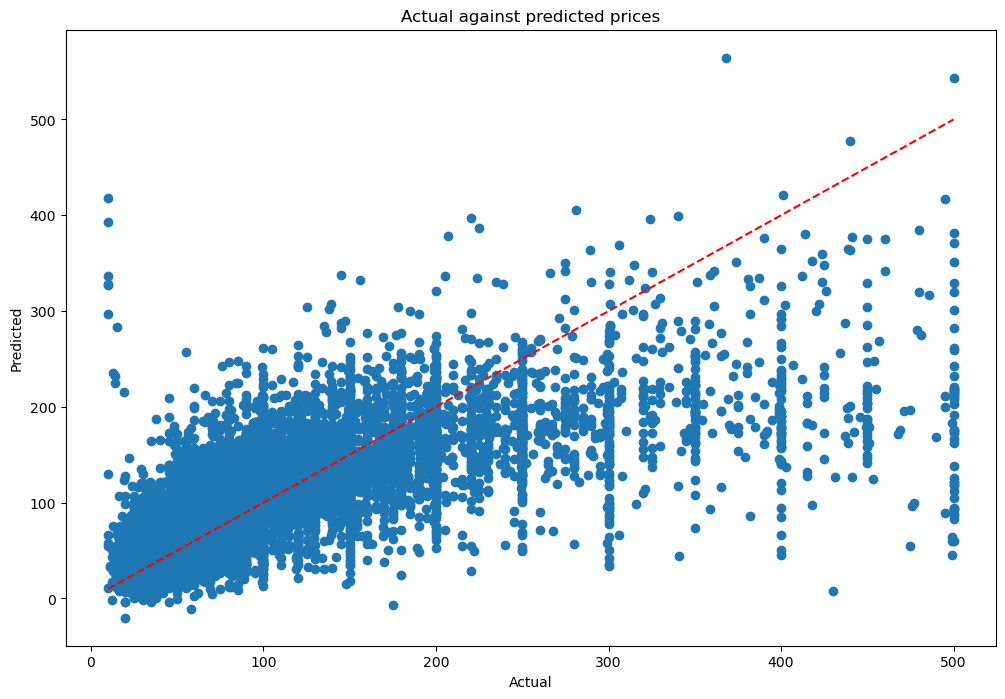

In [187]:
#Plot the actual prices against the predicted prices
y_pred_vn = model.predict(X_test_n)
plt.figure(figsize=(12, 8))
plt.scatter(y_test_vn, y_pred_vn)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual against predicted prices')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.show()

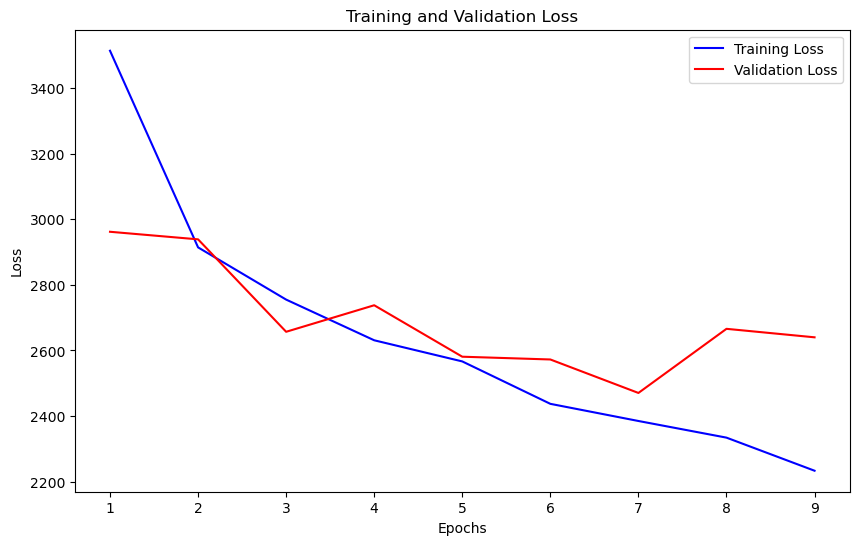

In [188]:
# Plotting training and validation loss by accessing the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

It seems like our network tends to have higher variance for targets with values above 200. We propose a strategy to divide our dataset based on this threshold and train separate networks. For entries below 200, we stick with the mse loss function which has shown good predictive power in our previous model. 
For entries above 200, we introduce a custom loss function. To further boost performance, we also include L1 regularization and dropout layers in our architecture.

Additionally, we notice that our validation loss plateaus and even starts to increase after a few epochs, signaling a potential overfitting issue. We will keep this in mind.

In [142]:
# Split training data into 200< price <200 
df_low = train[train['price'] <= 200]
df_high = train[train['price'] > 200]

# Features and target for <200 model
X_low = df_low[numerical_features]
y_low = df_low['price']

# Features and target for >1200 model
X_high = df_high[numerical_features]
y_high = df_high['price']

We start off predicting prices for our targets below 200

In [128]:

X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(X_low, y_low, test_size=0.2, random_state=42)
X_train_low, X_val_low, y_train_low, y_val_low = train_test_split(X_train_low, y_train_low, test_size=0.25, random_state=42)

# Initialize model
model = Sequential()

# Define architecture
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(256, activation='relu', kernel_regularizer=l1(0.01)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_regularizer=l1(0.01)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=l1(0.01)))
model.add(Dense(1, activation='linear'))

# Compile 
model.compile(optimizer='adam', loss=weighted_mse)

# Initialize 
early_stop = EarlyStopping(monitor='val_loss', patience=2)

# Training
model.fit(X_train_low, y_train_low, epochs=15, batch_size=32, validation_data=(X_val_low, y_val_low), callbacks=[early_stop])

# Evaluation
y_pred_low = model.predict(X_test_low)
mse = mean_squared_error(y_test_low, y_pred_low)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test_low, y_pred_low)
r2 = r2_score(y_test_low, y_pred_low)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Epoch 1/15


2023-09-02 14:42:32.195033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


939/939 [==============================] - ETA: 0s - loss: 1792.9341

2023-09-02 14:42:40.195559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


939/939 [==============================] - 9s 9ms/step - loss: 1792.9341 - val_loss: 1348.4880
Epoch 2/15
939/939 [==============================] - 6s 6ms/step - loss: 1333.9008 - val_loss: 1726.7349
Epoch 3/15
939/939 [==============================] - 5s 6ms/step - loss: 1304.8076 - val_loss: 1307.4581
Epoch 4/15
939/939 [==============================] - 5s 6ms/step - loss: 1304.1407 - val_loss: 1306.2817
Epoch 5/15
939/939 [==============================] - 5s 6ms/step - loss: 1295.4340 - val_loss: 1390.6068
Epoch 6/15
 99/313 [========>.....................] - ETA: 0s

2023-09-02 14:43:11.043511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
Mean Squared Error: 988.8857667157196
Root Mean Squared Error: 31.446554131028723
Mean Absolute Error: 24.252489518604897
R-squared: 0.55190003510683


As expected we observe that the error significantly decreases. We move on to the targets above 200 and employ a custom  loss function to better manage the high variance for these targets. Specifically higher values in the dataset receive greater weights which means the model will pay more attention to these instances during training. 

In [190]:
# Custom loss function 
def weighted_mse(y_true, y_pred):
    weights = y_true / tf.reduce_sum(y_true)
    loss = tf.reduce_sum(weights * tf.square(y_true - y_pred))
    return loss

# Splitting
X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(X_high, y_high, test_size=0.2, random_state=42)
X_train_high, X_val_high, y_train_high, y_val_high = train_test_split(X_train_high, y_train_high, test_size=0.25, random_state=42)

# Initialize  model
model = Sequential()

# Define Architecture
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(256, activation='relu', kernel_regularizer=l1(0.01)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_regularizer=l1(0.01)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=l1(0.01)))
model.add(Dense(1, activation='linear'))

# Compile 
model.compile(optimizer='adam', loss=weighted_mse)

# Iclude early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)

# Training
model.fit(X_train_high, y_train_high, epochs=15, batch_size=32, validation_data=(X_val_high, y_val_high), callbacks=[early_stop])

# Predict prices
y_pred_high = model.predict(X_test_high)

# Evaluation
mse = mean_squared_error(y_test_high, y_pred_high)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test_high, y_pred_high)
r2 = r2_score(y_test_high, y_pred_high)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Epoch 1/15


2023-09-02 20:43:46.478782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 25468.2285

2023-09-02 20:43:48.811806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 3s 20ms/step - loss: 25468.2285 - val_loss: 9466.8135
Epoch 2/15
98/98 [==============================] - 1s 6ms/step - loss: 8379.0576 - val_loss: 9469.2715
Epoch 3/15
98/98 [==============================] - 1s 6ms/step - loss: 8264.2715 - val_loss: 8866.0303
Epoch 4/15
98/98 [==============================] - 1s 7ms/step - loss: 7866.0767 - val_loss: 8648.1738
Epoch 5/15
98/98 [==============================] - 1s 6ms/step - loss: 7862.8203 - val_loss: 8521.3604
Epoch 6/15
98/98 [==============================] - 1s 6ms/step - loss: 7932.2769 - val_loss: 8382.9287
Epoch 7/15
98/98 [==============================] - 1s 6ms/step - loss: 7585.2944 - val_loss: 8377.7510
Epoch 8/15
98/98 [==============================] - 1s 7ms/step - loss: 7649.2363 - val_loss: 8206.6016
Epoch 9/15
98/98 [==============================] - 1s 6ms/step - loss: 7666.5332 - val_loss: 8238.6641
Epoch 10/15
98/98 [==============================] - 1s 6ms/step - loss: 

2023-09-02 20:43:56.524931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


It is at this point where we encounter the limitations of this approach. Afrer examining the dataset sizes we realize the limitations of splitting the data by the target. Specifically, the "above 200" dataset contains only 5000 entries which is not enough for effective model training. While data augmentation is an option, we decide not to pursue it. Even the best synthetic data generated through methods like Gaussian noise cant fully replicate realworld conditions. This approach would also bring the challenge of ordering test data to either the above or below 200 price range. However, this issue could be addressed by training a simple decision tree to make this classification based on the remaining features.

#### 5.2.3 Optimization and Hyperparameter-Tuning

Having recognized the limitations of our dataset size and chosen not to augment the data, we shift our focus to refining our Vanilla Neural Network through hyperparameter tuning. To systematically explore the optimal settings, we employ a simple grid search, looking for the optimal combination of the Number of hidden layer, nodes and the learning rate.

In [152]:
# Define grid
hidden_layers_options = [2, 4, 6]  # Number of hidden layers
nodes_options = [64, 128, 256, 512]  # Nodes in each layer
lr_options = [0.001, 0.01, 0.1]  # Learning rate

best_val_loss = float('inf')  # Initialize best validation loss
best_params = {}  # Dictionary for storing the best parameters

# Counters for total and current iterations
total_iterations = len(hidden_layers_options) * len(nodes_options) * len(lr_options)
current_iteration = 1

# Apply Grid search
for hidden_layers in hidden_layers_options:
    for nodes in nodes_options:
        for lr in lr_options:
            
            print(f"Starting iteration {current_iteration}/{total_iterations}...")
            print(f"Testing with hidden_layers: {hidden_layers}, nodes: {nodes}, lr: {lr}")
            
            # Build and compile 
            model = Sequential()
            model.add(Input(shape=(X_train_vn.shape[1],)))
            
            for i in range(hidden_layers):
                model.add(Dense(nodes, activation='relu'))
            
            model.add(Dense(1, activation='linear'))
            
            optimizer = Adam(learning_rate=lr)
            model.compile(optimizer=optimizer, loss='mse')
            
            # Train 
            model.fit(X_train_vn, y_train_vn, epochs=10, batch_size=32, verbose=0)
            
            # Validate 
            val_loss = model.evaluate(X_val_vn, y_val_vn, verbose=0)
            
            print(f"Validation loss for this iteration: {val_loss}")
            
            # compare performance to previous best 
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = {'hidden_layers': hidden_layers, 'nodes': nodes, 'lr': lr}
                print(f"New best validation loss: {best_val_loss}")

            current_iteration += 1

print(f"Best Validation Loss: {best_val_loss}")
print(f"Best Parameters: {best_params}")

Starting iteration 1/36...
Testing with hidden_layers: 2, nodes: 64, lr: 0.001


2023-09-02 15:43:28.837152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:44:03.037199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2858.02685546875
New best validation loss: 2858.02685546875
Starting iteration 2/36...
Testing with hidden_layers: 2, nodes: 64, lr: 0.01


2023-09-02 15:44:03.971891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:44:37.876954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2671.232666015625
New best validation loss: 2671.232666015625
Starting iteration 3/36...
Testing with hidden_layers: 2, nodes: 64, lr: 0.1


2023-09-02 15:44:38.795381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:45:12.603538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2890.19580078125
Starting iteration 4/36...
Testing with hidden_layers: 2, nodes: 128, lr: 0.001


2023-09-02 15:45:13.552454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:45:47.652887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2886.734130859375
Starting iteration 5/36...
Testing with hidden_layers: 2, nodes: 128, lr: 0.01


2023-09-02 15:45:48.578175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:46:22.739627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2597.91357421875
New best validation loss: 2597.91357421875
Starting iteration 6/36...
Testing with hidden_layers: 2, nodes: 128, lr: 0.1


2023-09-02 15:46:23.683259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:46:57.848138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2842.00244140625
Starting iteration 7/36...
Testing with hidden_layers: 2, nodes: 256, lr: 0.001


2023-09-02 15:46:58.815074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:47:33.316466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2701.200927734375
Starting iteration 8/36...
Testing with hidden_layers: 2, nodes: 256, lr: 0.01


2023-09-02 15:47:34.250767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:48:10.420959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2563.180419921875
New best validation loss: 2563.180419921875
Starting iteration 9/36...
Testing with hidden_layers: 2, nodes: 256, lr: 0.1


2023-09-02 15:48:13.050006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:48:47.957903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2882.944091796875
Starting iteration 10/36...
Testing with hidden_layers: 2, nodes: 512, lr: 0.001


2023-09-02 15:48:48.927876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:49:24.764069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2598.603759765625
Starting iteration 11/36...
Testing with hidden_layers: 2, nodes: 512, lr: 0.01


2023-09-02 15:49:25.703123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:50:01.315329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2546.441650390625
New best validation loss: 2546.441650390625
Starting iteration 12/36...
Testing with hidden_layers: 2, nodes: 512, lr: 0.1


2023-09-02 15:50:02.264170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:50:37.850659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2992.568603515625
Starting iteration 13/36...
Testing with hidden_layers: 4, nodes: 64, lr: 0.001


2023-09-02 15:50:38.816052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:51:20.708232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2596.24462890625
Starting iteration 14/36...
Testing with hidden_layers: 4, nodes: 64, lr: 0.01


2023-09-02 15:51:21.754531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:52:04.187260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2569.906494140625
Starting iteration 15/36...
Testing with hidden_layers: 4, nodes: 64, lr: 0.1


2023-09-02 15:52:05.268185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:52:48.002466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 3126.52734375
Starting iteration 16/36...
Testing with hidden_layers: 4, nodes: 128, lr: 0.001


2023-09-02 15:52:49.090166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:53:32.911376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2539.536865234375
New best validation loss: 2539.536865234375
Starting iteration 17/36...
Testing with hidden_layers: 4, nodes: 128, lr: 0.01


2023-09-02 15:53:34.007981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:54:17.445733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2589.447509765625
Starting iteration 18/36...
Testing with hidden_layers: 4, nodes: 128, lr: 0.1


2023-09-02 15:54:18.934562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:55:02.161167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 6992.287109375
Starting iteration 19/36...
Testing with hidden_layers: 4, nodes: 256, lr: 0.001


2023-09-02 15:55:03.223083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:55:46.776705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2578.942138671875
Starting iteration 20/36...
Testing with hidden_layers: 4, nodes: 256, lr: 0.01


2023-09-02 15:55:47.844619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:56:31.435525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2682.22998046875
Starting iteration 21/36...
Testing with hidden_layers: 4, nodes: 256, lr: 0.1


2023-09-02 15:56:32.509370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:57:16.838890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 6992.67724609375
Starting iteration 22/36...
Testing with hidden_layers: 4, nodes: 512, lr: 0.001


2023-09-02 15:57:17.903063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:58:02.339149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2546.152587890625
Starting iteration 23/36...
Testing with hidden_layers: 4, nodes: 512, lr: 0.01


2023-09-02 15:58:03.398087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:58:47.430657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2630.447265625
Starting iteration 24/36...
Testing with hidden_layers: 4, nodes: 512, lr: 0.1


2023-09-02 15:58:48.510976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 15:59:33.063917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 7002.16064453125
Starting iteration 25/36...
Testing with hidden_layers: 6, nodes: 64, lr: 0.001


2023-09-02 15:59:34.191292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 16:00:25.552812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2628.33056640625
Starting iteration 26/36...
Testing with hidden_layers: 6, nodes: 64, lr: 0.01


2023-09-02 16:00:26.835825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 16:01:17.351632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2732.0771484375
Starting iteration 27/36...
Testing with hidden_layers: 6, nodes: 64, lr: 0.1


2023-09-02 16:01:18.524811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 16:02:08.328414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 6993.72900390625
Starting iteration 28/36...
Testing with hidden_layers: 6, nodes: 128, lr: 0.001


2023-09-02 16:02:09.505602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 16:03:01.633113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2713.227783203125
Starting iteration 29/36...
Testing with hidden_layers: 6, nodes: 128, lr: 0.01


2023-09-02 16:03:02.845141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 16:03:53.787723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2621.577880859375
Starting iteration 30/36...
Testing with hidden_layers: 6, nodes: 128, lr: 0.1


2023-09-02 16:03:54.989971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 16:04:45.540583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 7060.4755859375
Starting iteration 31/36...
Testing with hidden_layers: 6, nodes: 256, lr: 0.001


2023-09-02 16:04:46.724432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 16:05:41.463775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2455.490478515625
New best validation loss: 2455.490478515625
Starting iteration 32/36...
Testing with hidden_layers: 6, nodes: 256, lr: 0.01


2023-09-02 16:05:42.689444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 16:06:36.417810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2738.304443359375
Starting iteration 33/36...
Testing with hidden_layers: 6, nodes: 256, lr: 0.1


2023-09-02 16:06:37.654039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 16:07:31.398436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 7424.07958984375
Starting iteration 34/36...
Testing with hidden_layers: 6, nodes: 512, lr: 0.001


2023-09-02 16:07:32.643691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 16:08:28.332224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2635.895263671875
Starting iteration 35/36...
Testing with hidden_layers: 6, nodes: 512, lr: 0.01


2023-09-02 16:08:29.551403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 16:09:25.420819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 2732.78076171875
Starting iteration 36/36...
Testing with hidden_layers: 6, nodes: 512, lr: 0.1


2023-09-02 16:09:26.685829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-02 16:10:22.601358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Validation loss for this iteration: 17483.53515625
Best Validation Loss: 2455.490478515625
Best Parameters: {'hidden_layers': 6, 'nodes': 256, 'lr': 0.001}


We end up with the following: 
'Best Validation Loss: 2455.490478515625'
'Best Parameters: {'hidden_layers': 6, 'nodes': 256, 'lr': 0.001}'

Concluding our Hyperparametertuning we end up with a Neural network which is able to predict our target with a RMSE of ~50

### 5.3 Final Model Choice and Fine-Tuning

After completing our hyperparameter tuning we find that our Neural Network model is worse in predicting prices compared to our XGB model. It holds the best performance with a RMSE of ~45. This difference is significant enough to select the XGB model as our final choice. 
In contrast, the worst-performing model, an XGB model trained solely on textual features, had an RMSE of 56. Given this, we opt to exclude pure textual features and instead focus on the statistics derived from them, which weve stored in 'textual_stats.'

To further refine our chosen XGB model, we plan to execute another grid search for hyperparameter optimization. Specifically, we aim to identify the 
- optimal settings for the number of boosting rounds
- learning rate
- maximum tree depth
- fraction of training data sampled for each tree
- fraction of features selected for each boosting round.

In [157]:
# Features and target
# add textual_stats as our XGB above performed slightly better with them 
X = pd.concat([train[numerical_features], textual_stats], axis=1)
y = train['price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define grid
n_estimators_options = [50, 100, 200]
learning_rate_options = [0.01, 0.05, 0.1]
max_depth_options = [3, 5, 10]
subsample_options = [0.7, 0.8, 0.9]
colsample_bytree_options = [0.6, 0.8, 1.0]

best_rmse = float('inf')
best_params = {}

total_iterations = len(n_estimators_options) * len(learning_rate_options) * len(max_depth_options) * len(subsample_options) * len(colsample_bytree_options)
current_iteration = 1

# Apply grid going through the 240+ combinations of the above parameters
for n_estimators in n_estimators_options:
    for learning_rate in learning_rate_options:
        for max_depth in max_depth_options:
            for subsample in subsample_options:
                for colsample_bytree in colsample_bytree_options:

                    print(f"Starting iteration {current_iteration}/{total_iterations}...")
                    print(f"Testing with n_estimators: {n_estimators}, learning_rate: {learning_rate}, max_depth: {max_depth}, subsample: {subsample}, colsample_bytree: {colsample_bytree}")

                    model = xgb.XGBRegressor(
                        n_estimators=n_estimators,
                        learning_rate=learning_rate,
                        max_depth=max_depth,
                        subsample=subsample,
                        colsample_bytree=colsample_bytree,
                        random_state=42
                    )
                    
                    model.fit(X_train, y_train)
                    
                    y_pred = model.predict(X_valid)
                    
                    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
                    print(f"Validation RMSE for this iteration: {rmse}")
                    
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = {
                            'n_estimators': n_estimators,
                            'learning_rate': learning_rate,
                            'max_depth': max_depth,
                            'subsample': subsample,
                            'colsample_bytree': colsample_bytree
                        }
                        print(f"New best RMSE: {best_rmse}")

                    current_iteration += 1

print(f"Best Validation RMSE: {best_rmse}")
print(f"Best Parameters: {best_params}")


Starting iteration 1/243...
Testing with n_estimators: 50, learning_rate: 0.01, max_depth: 3, subsample: 0.7, colsample_bytree: 0.6
Validation RMSE for this iteration: 94.71476992330578
New best RMSE: 94.71476992330578
Starting iteration 2/243...
Testing with n_estimators: 50, learning_rate: 0.01, max_depth: 3, subsample: 0.7, colsample_bytree: 0.8
Validation RMSE for this iteration: 94.41301014191897
New best RMSE: 94.41301014191897
Starting iteration 3/243...
Testing with n_estimators: 50, learning_rate: 0.01, max_depth: 3, subsample: 0.7, colsample_bytree: 1.0
Validation RMSE for this iteration: 94.24289688902151
New best RMSE: 94.24289688902151
Starting iteration 4/243...
Testing with n_estimators: 50, learning_rate: 0.01, max_depth: 3, subsample: 0.8, colsample_bytree: 0.6
Validation RMSE for this iteration: 94.70512246886437
Starting iteration 5/243...
Testing with n_estimators: 50, learning_rate: 0.01, max_depth: 3, subsample: 0.8, colsample_bytree: 0.8
Validation RMSE for this 

Validation RMSE for this iteration: 53.40569668720282
Starting iteration 42/243...
Testing with n_estimators: 50, learning_rate: 0.05, max_depth: 5, subsample: 0.8, colsample_bytree: 1.0
Validation RMSE for this iteration: 53.28487148178814
New best RMSE: 53.28487148178814
Starting iteration 43/243...
Testing with n_estimators: 50, learning_rate: 0.05, max_depth: 5, subsample: 0.9, colsample_bytree: 0.6
Validation RMSE for this iteration: 53.44231964832956
Starting iteration 44/243...
Testing with n_estimators: 50, learning_rate: 0.05, max_depth: 5, subsample: 0.9, colsample_bytree: 0.8
Validation RMSE for this iteration: 53.269030525412326
New best RMSE: 53.269030525412326
Starting iteration 45/243...
Testing with n_estimators: 50, learning_rate: 0.05, max_depth: 5, subsample: 0.9, colsample_bytree: 1.0
Validation RMSE for this iteration: 53.32110659824263
Starting iteration 46/243...
Testing with n_estimators: 50, learning_rate: 0.05, max_depth: 10, subsample: 0.7, colsample_bytree: 

Validation RMSE for this iteration: 74.28907131069745
Starting iteration 83/243...
Testing with n_estimators: 100, learning_rate: 0.01, max_depth: 3, subsample: 0.7, colsample_bytree: 0.8
Validation RMSE for this iteration: 74.04062184557223
Starting iteration 84/243...
Testing with n_estimators: 100, learning_rate: 0.01, max_depth: 3, subsample: 0.7, colsample_bytree: 1.0
Validation RMSE for this iteration: 73.89427189044243
Starting iteration 85/243...
Testing with n_estimators: 100, learning_rate: 0.01, max_depth: 3, subsample: 0.8, colsample_bytree: 0.6
Validation RMSE for this iteration: 74.3143310326263
Starting iteration 86/243...
Testing with n_estimators: 100, learning_rate: 0.01, max_depth: 3, subsample: 0.8, colsample_bytree: 0.8
Validation RMSE for this iteration: 74.00731454834798
Starting iteration 87/243...
Testing with n_estimators: 100, learning_rate: 0.01, max_depth: 3, subsample: 0.8, colsample_bytree: 1.0
Validation RMSE for this iteration: 73.89055258785471
Startin

Validation RMSE for this iteration: 49.851691769130106
Starting iteration 127/243...
Testing with n_estimators: 100, learning_rate: 0.05, max_depth: 10, subsample: 0.7, colsample_bytree: 0.6
Validation RMSE for this iteration: 46.19619968342586
New best RMSE: 46.19619968342586
Starting iteration 128/243...
Testing with n_estimators: 100, learning_rate: 0.05, max_depth: 10, subsample: 0.7, colsample_bytree: 0.8
Validation RMSE for this iteration: 46.120078116041846
New best RMSE: 46.120078116041846
Starting iteration 129/243...
Testing with n_estimators: 100, learning_rate: 0.05, max_depth: 10, subsample: 0.7, colsample_bytree: 1.0
Validation RMSE for this iteration: 46.30261328793683
Starting iteration 130/243...
Testing with n_estimators: 100, learning_rate: 0.05, max_depth: 10, subsample: 0.8, colsample_bytree: 0.6
Validation RMSE for this iteration: 46.147479336922316
Starting iteration 131/243...
Testing with n_estimators: 100, learning_rate: 0.05, max_depth: 10, subsample: 0.8, co

Validation RMSE for this iteration: 59.51172848200317
Starting iteration 169/243...
Testing with n_estimators: 200, learning_rate: 0.01, max_depth: 3, subsample: 0.9, colsample_bytree: 0.6
Validation RMSE for this iteration: 59.60945052370356
Starting iteration 170/243...
Testing with n_estimators: 200, learning_rate: 0.01, max_depth: 3, subsample: 0.9, colsample_bytree: 0.8
Validation RMSE for this iteration: 59.47068793612551
Starting iteration 171/243...
Testing with n_estimators: 200, learning_rate: 0.01, max_depth: 3, subsample: 0.9, colsample_bytree: 1.0
Validation RMSE for this iteration: 59.538258634999984
Starting iteration 172/243...
Testing with n_estimators: 200, learning_rate: 0.01, max_depth: 5, subsample: 0.7, colsample_bytree: 0.6
Validation RMSE for this iteration: 56.24043757015878
Starting iteration 173/243...
Testing with n_estimators: 200, learning_rate: 0.01, max_depth: 5, subsample: 0.7, colsample_bytree: 0.8
Validation RMSE for this iteration: 55.898439279997696

Validation RMSE for this iteration: 45.23059679580121
Starting iteration 212/243...
Testing with n_estimators: 200, learning_rate: 0.05, max_depth: 10, subsample: 0.8, colsample_bytree: 0.8
Validation RMSE for this iteration: 45.13878274412967
Starting iteration 213/243...
Testing with n_estimators: 200, learning_rate: 0.05, max_depth: 10, subsample: 0.8, colsample_bytree: 1.0
Validation RMSE for this iteration: 45.38735217996452
Starting iteration 214/243...
Testing with n_estimators: 200, learning_rate: 0.05, max_depth: 10, subsample: 0.9, colsample_bytree: 0.6
Validation RMSE for this iteration: 45.20431767357362
Starting iteration 215/243...
Testing with n_estimators: 200, learning_rate: 0.05, max_depth: 10, subsample: 0.9, colsample_bytree: 0.8
Validation RMSE for this iteration: 44.9972860674148
New best RMSE: 44.9972860674148
Starting iteration 216/243...
Testing with n_estimators: 200, learning_rate: 0.05, max_depth: 10, subsample: 0.9, colsample_bytree: 1.0
Validation RMSE for

'Best Validation RMSE: 44.9972860674148'

'Best Parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 10, 'subsample': 0.9, 'colsample_bytree': 0.8}'

We build a final model using these configurations

In [160]:
# Feature and Target 
X = train[numerical_features]  
X = pd.concat([X, textual_stats], axis=1)
y = train['price'] 

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Resetting the index 
X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)

# Initilize model and set parameters determined in grid search
xgb_model = xgb.XGBRegressor(
    n_estimators=200,             
    learning_rate=0.05,           
    max_depth=10,                 
    subsample=0.9,                
    colsample_bytree=0.8,         
    random_state=42               
)
# Training
xgb_model.fit(X_train, y_train)

# Predict prices
y_pred_xgb_num = xgb_model.predict(X_valid)

# Evaluation
mse = mean_squared_error(y_valid, y_pred_xgb_num)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)
print("Mean Squared Error:", mse)

Root Mean Squared Error: 44.9972860674148
Mean Squared Error: 2024.755753432762


## 6. Application to Test Set
### 6.1 Preprocessing Test Data

Before making predictions on our test set, it is crucial to preprocess it in the same way we did for "train". To maintain readability, we haveve put the preprocessing steps into a separate function stored in an external file (help_functions.py). After applying the function, we make sure that we indeed processed it in the way intended by quickly comparing it to our train dataset.

In [54]:
test = pd.read_csv("csv_files/test.csv", sep=",",index_col=False, encoding="utf-8")

test = preprocess_test(test)
# make sure that we indeed processed it likt our train dataset by comparing the two

In [168]:
test.head(1)

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,host_id,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,guests_included,cancellation_policy,reviews_per_month,listing_id,host_response_missing,review_missing,years_since_registration,review_scores
0,ladbroke grove stylish portobello apartment,large <comma> bright contemporary flat located heart ladbroke grove <dot> recently renovated <co...,provided,large <comma> bright contemporary flat located heart ladbroke grove <dot> recently renovated <co...,2.0,provided,provided,provided,28086957,1.0,1.0,0.0,1.0,1.0,1.0,19.0,6.0,51.518372,-0.21065,1.0,0.0,2.0,1.0,1.0,1.0,4.0,tv <comma> cable tv <comma> internet <comma> wifi <comma> kitchen <comma> heating <comma> washer...,1.0,0.0,1.89,0FEMC4VA5U,1.0,0.0,6.0,9.942857


In [68]:
train.head(1)

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,host_id,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,cancellation_policy,reviews_per_month,listing_id,host_response_missing,review_missing,price_log,years_since_registration,review_scores
0,attic room historic greenwich,room door discreet staircase <dot> light <comma> airy open plan <dot> leaning ceiling provides s...,double room available historic royal greenwich <special> unesco designated world heritage site s...,room door discreet staircase <dot> light <comma> airy open plan <dot> leaning ceiling provides s...,0.0,provided,parking restricted london <dot> visitor parking permit area available <pound> <num> per day <dot...,shoe carpet food attic room guest invited back house,2167992,1.0,1.0,1.0,1.0,1.0,0.0,10.0,4.0,51.474571,-0.01062,33.0,2.0,2.0,1.0,1.0,1.0,3.0,wifi <comma> paid parking premise <comma> heating <comma> washer <comma> smoke detector <comma> ...,35.0,1.0,5.0,2.37,9Q1RD6H7IO,0.0,0.0,3.583519,9.0,9.928572


As this looks good, we generate the statistical features from our textual_features for our test set in a last step

In [ ]:
textual_stats_test = pd.DataFrame()

for col in textual_features:
    new_stats = extract_textual_statistics(test, col)
    textual_stats_test = pd.concat([textual_stats_test, new_stats], axis=1)

### 6.2 Price Estimation on Test Data 

We finally arrive at the moment of truth. We train our model on the entire training set, predict the prices using the features in our test set and save the results in the required csv format.

In [167]:
# Target and Feature
X = train[numerical_features] 
X = pd.concat([X, textual_stats], axis=1)
y = train['price']  

# Initialize model
xgb_model_final = xgb.XGBRegressor(
    n_estimators=200,             
    learning_rate=0.05,           
    max_depth=10,                 
    subsample=0.9,                
    colsample_bytree=0.8,         
    random_state=42               
)

# Final Training 
xgb_model_final.fit(X, y)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [172]:
# Make Predictions 
X = test[numerical_features] 
X = pd.concat([X, textual_stats_test], axis=1)

y_pred_xgb_test = xgb_model_final.predict(X)

# Save in CSV in desired format 
result_df = pd.DataFrame({
    'listing_id': test['listing_id'],  
    'price': y_pred_xgb_test
})

result_df.to_csv('predictions.csv', index=False)

## 7. Conclusion

This assignment took us on a journey through the, at least for me, unexpected complexity of real-world data. We analyzed the properties of  AirBnB listings, with the aim of predicting property prices. We were constrained in some ways, especially when it came to computational resources. I really wish we could have gone deeper into analyzing the textual features with high dimensional embeddings. Sentiment analysis on the review.csv would have also been super interesting. Nonetheless, we managed to extract some value from the textual features, and our intuition was largely confirmed that the numerical features were the main drivers of predictive power.

Going forward, theres room for improvement. Trying out additional models and focusing on better feature selection could give us more accurate results. All in all, this project was both challenging and insightful, revealing not just the capabilities of various models but also the limitations we face in data science today.